# Generador de rostros artificiales mediante redes adversativas

En este se usara imagenes de menor tamaño (128x128 -> 32x32 )

En una red adversaria se tienen dos modelos (que pueden ser Redes Neuronales o Convolucionales) compitiendo: un Generador y un Discriminador.

Se genera un primer modelo que llamaremos Discriminador para que sea capaz de reconocer rostros humanos. Este discriminador será simplemente un clasificador,que buscara indicar si una imagen es real o falsa

Se genera un segundo modelo, que llamaremos Generador y nuestro objetivo es entrenarlo para que sea capaz de tomar una entrada aleatoria y a la salida generar algo muy parecido a una imagen de un rostro.

La idea es entrenar esos dos modelos simultáneamente buscando que al final sea el Generador el vencedor en esta competencia.



In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2

### Carga de datos

In [2]:
def cargar_datos(dataset):
    print('Creando set de entrenamiento...')
    filelist = os.listdir(dataset)

    n_imgs = len(filelist)
    x_train = np.zeros((n_imgs,32,32,3))

    for i in range(n_imgs):
        direcion = str(dataset)+ "\\" + str(filelist[i])
        imagen = cv2.imread(direcion,1)
        imagen = cv2.cvtColor(imagen, cv2.COLOR_BGR2RGB)
        imagen = cv2.resize(imagen, dsize=(32, 32))
        x_train[i,:] = (imagen - 127.5)/127.5 #para dejarlo entre -1 y 1
    print('¡Listo!')

    return x_train

x_train = cargar_datos("dataset1")

Creando set de entrenamiento...
¡Listo!


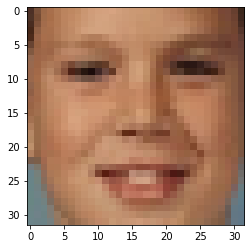

In [3]:
def visualizar_imagen(nimagen,x_train):
    imagen = (x_train[nimagen] * 0.5) + 0.5 #para pasarlo de 0 a 1
    plt.imshow(imagen)
    plt.show()

visualizar_imagen(4,x_train)

### Creacion de los modelos

In [4]:
from keras.models import Sequential, Model
from keras.layers import Dense, Reshape, Conv2DTranspose, BatchNormalization, Conv2D, LeakyReLU, Flatten, Input, UpSampling2D
from keras.layers.core import Activation

In [5]:
TAM_LOTE = 150 
TAM_ENTRADA = 100
N_ITS = 5000
import time

In [7]:
def crear_generador(TAM_ENTRADA):
    modelo = Sequential(name = "Generador")
    
    modelo.add(Dense(32*32*3, use_bias=False, input_shape=(TAM_ENTRADA,)))
    modelo.add(Reshape((32,32,3)))
    #Tamaño resultante: 32x32x3
    
    # downsampling
    modelo.add(Conv2D(32,4, strides=2, padding='same',kernel_initializer='he_normal', use_bias=False))
    modelo.add(BatchNormalization())
    modelo.add(LeakyReLU())
    #Tamaño resultante: 16x16x32
    
    modelo.add(Conv2D(64,4, strides=2, padding='same',kernel_initializer='he_normal', use_bias=False))
    modelo.add(BatchNormalization())
    modelo.add(LeakyReLU())
    #Tamaño resultante: 8x8x64
    
    modelo.add(Conv2DTranspose(32, 4, strides=1,padding='same',kernel_initializer='he_normal',use_bias=False))
    modelo.add(Conv2DTranspose(32, 4, strides=2,padding='same',kernel_initializer='he_normal',use_bias=False))
    modelo.add(BatchNormalization())
    #Tamaño resultante: 16x16x32
    
    modelo.add(Conv2DTranspose(16, 4, strides=1,padding='same',kernel_initializer='he_normal',use_bias=False))
    modelo.add(Conv2DTranspose(16, 4, strides=2,padding='same',kernel_initializer='he_normal',use_bias=False))
    modelo.add(BatchNormalization())
    #Tamaño resultante: 32x32x16
    
    modelo.add(Conv2DTranspose(3, 4, strides = 1, padding='same',kernel_initializer='he_normal',use_bias=False))
    modelo.add(Conv2DTranspose(3, 4, strides = 1, padding = 'same',activation = 'tanh'))
    #Tamaño resultante: 32x32x3
    
    modelo.compile(optimizer="Adam", loss="binary_crossentropy")

    return modelo

generador = crear_generador(TAM_ENTRADA)
generador.summary()

Model: "Generador"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 3072)              307200    
_________________________________________________________________
reshape_1 (Reshape)          (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 16, 16, 32)        1536      
_________________________________________________________________
batch_normalization (BatchNo (None, 16, 16, 32)        128       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 64)          32768     
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 8, 64)          25

In [8]:
def crear_discriminador():
    
    modelo = Sequential(name = "Discriminador")

    modelo.add(Conv2D(32, 4, strides=2, padding='same',kernel_initializer='he_normal', input_shape=(32,32,3), use_bias=False))
    modelo.add(BatchNormalization())
    modelo.add(LeakyReLU())
    #16x16x32

    modelo.add(Conv2D(64, 4, strides=2, padding='same',kernel_initializer='he_normal', use_bias=False))
    modelo.add(BatchNormalization())
    modelo.add(LeakyReLU())
    #8x8x64

    modelo.add(Conv2D(128, 4, strides=2, padding='same',kernel_initializer='he_normal', use_bias=False))
    modelo.add(BatchNormalization())
    modelo.add(LeakyReLU())
    #4x4x128

    modelo.add(Flatten())
    modelo.add(Dense(1, activation='sigmoid'))

    modelo.compile(optimizer="Adam", loss="binary_crossentropy")

    return modelo

discriminador = crear_discriminador()
discriminador.summary()

Model: "Discriminador"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 16, 16, 32)        1536      
_________________________________________________________________
batch_normalization_4 (Batch (None, 16, 16, 32)        128       
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 64)          32768     
_________________________________________________________________
batch_normalization_5 (Batch (None, 8, 8, 64)          256       
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 4, 4, 128)       

In [9]:
def crear_GAN(generador, discriminador):
    modelo = Sequential(name = "GAN")
    modelo.add(generador)
    discriminador.trainable = False
    modelo.add(discriminador)
    modelo.compile(optimizer="Adam", loss="binary_crossentropy")

    return modelo

gan = crear_GAN(generador, discriminador)

gan.summary()

Model: "GAN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Generador (Sequential)       (None, 32, 32, 3)         404435    
_________________________________________________________________
Discriminador (Sequential)   (None, 1)                 168321    
Total params: 572,756
Trainable params: 404,147
Non-trainable params: 168,609
_________________________________________________________________


### Entrenamiento

En el caso de las Redes Adversarias debemos llevar a cabo estos pasos:

1. “Descongelar” los coeficientes del Discriminador
2. Entrenar solo el Discriminador con imagenes falsas y reales
3. “Congelar” los coeficientes del Discriminador
4. Entrenar la GAN, al estar congelado el discriminador únicamente se entrenara el Generador
5. Repetir los pasos 1 a 4 por el número de iteraciones que se vayan a usar el entrenamiento

Comenzando Epoca 1
Fin
Tiempo transcurrido:  2.019508123397827
Comenzando Epoca 2
Fin
Tiempo transcurrido:  0.6610116958618164
Comenzando Epoca 3
Fin
Tiempo transcurrido:  0.6764147281646729
Comenzando Epoca 4
Fin
Tiempo transcurrido:  0.6454453468322754
Comenzando Epoca 5
Fin
Tiempo transcurrido:  0.6550314426422119
Comenzando Epoca 6
Fin
Tiempo transcurrido:  0.6864361763000488
Comenzando Epoca 7
Fin
Tiempo transcurrido:  0.6564533710479736
Comenzando Epoca 8
Fin
Tiempo transcurrido:  0.6796257495880127
Comenzando Epoca 9
Fin
Tiempo transcurrido:  0.6526570320129395
Comenzando Epoca 10
Fin
Tiempo transcurrido:  0.7424688339233398
Comenzando Epoca 11
Fin
Tiempo transcurrido:  0.6700263023376465
Comenzando Epoca 12
Fin
Tiempo transcurrido:  0.6604130268096924
Comenzando Epoca 13
Fin
Tiempo transcurrido:  0.6528134346008301
Comenzando Epoca 14
Fin
Tiempo transcurrido:  0.6558139324188232
Comenzando Epoca 15
Fin
Tiempo transcurrido:  0.6788434982299805
Comenzando Epoca 16
Fin
Tiempo tran

Fin
Tiempo transcurrido:  0.6552083492279053
Comenzando Epoca 64
Fin
Tiempo transcurrido:  0.6748092174530029
Comenzando Epoca 65
Fin
Tiempo transcurrido:  0.641608476638794
Comenzando Epoca 66
Fin
Tiempo transcurrido:  0.6552081108093262
Comenzando Epoca 67
Fin
Tiempo transcurrido:  0.6718087196350098
Comenzando Epoca 68
Fin
Tiempo transcurrido:  0.7050094604492188
Comenzando Epoca 69
Fin
Tiempo transcurrido:  0.7350120544433594
Comenzando Epoca 70
Fin
Tiempo transcurrido:  0.640608549118042
Comenzando Epoca 71
Fin
Tiempo transcurrido:  0.641608476638794
Comenzando Epoca 72
Fin
Tiempo transcurrido:  0.6396079063415527
Comenzando Epoca 73
Fin
Tiempo transcurrido:  0.6708085536956787
Comenzando Epoca 74
Fin
Tiempo transcurrido:  0.7020092010498047
Comenzando Epoca 75
Fin
Tiempo transcurrido:  0.7020089626312256
Comenzando Epoca 76
Fin
Tiempo transcurrido:  0.7020089626312256
Comenzando Epoca 77
Fin
Tiempo transcurrido:  0.6864089965820312
Comenzando Epoca 78
Fin
Tiempo transcurrido:  0.

Fin
Tiempo transcurrido:  0.6552085876464844
Comenzando Epoca 126
Fin
Tiempo transcurrido:  0.6746115684509277
Comenzando Epoca 127
Fin
Tiempo transcurrido:  0.6728088855743408
Comenzando Epoca 128
Fin
Tiempo transcurrido:  0.6552083492279053
Comenzando Epoca 129
Fin
Tiempo transcurrido:  0.6552083492279053
Comenzando Epoca 130
Fin
Tiempo transcurrido:  0.6552083492279053
Comenzando Epoca 131
Fin
Tiempo transcurrido:  0.6552083492279053
Comenzando Epoca 132
Fin
Tiempo transcurrido:  0.6552085876464844
Comenzando Epoca 133
Fin
Tiempo transcurrido:  0.6396081447601318
Comenzando Epoca 134
Fin
Tiempo transcurrido:  0.6552083492279053
Comenzando Epoca 135
Fin
Tiempo transcurrido:  0.6396081447601318
Comenzando Epoca 136
Fin
Tiempo transcurrido:  0.6552085876464844
Comenzando Epoca 137
Fin
Tiempo transcurrido:  0.6396081447601318
Comenzando Epoca 138
Fin
Tiempo transcurrido:  0.6552083492279053
Comenzando Epoca 139
Fin
Tiempo transcurrido:  0.6396083831787109
Comenzando Epoca 140
Fin
Tiempo

Fin
Tiempo transcurrido:  0.6552083492279053
Comenzando Epoca 188
Fin
Tiempo transcurrido:  0.6562085151672363
Comenzando Epoca 189
Fin
Tiempo transcurrido:  0.6396081447601318
Comenzando Epoca 190
Fin
Tiempo transcurrido:  0.6552083492279053
Comenzando Epoca 191
Fin
Tiempo transcurrido:  0.6396083831787109
Comenzando Epoca 192
Fin
Tiempo transcurrido:  0.6396079063415527
Comenzando Epoca 193
Fin
Tiempo transcurrido:  0.6396081447601318
Comenzando Epoca 194
Fin
Tiempo transcurrido:  0.6396083831787109
Comenzando Epoca 195
Fin
Tiempo transcurrido:  0.6552081108093262
Comenzando Epoca 196
Fin
Tiempo transcurrido:  0.6552083492279053
Comenzando Epoca 197
Fin
Tiempo transcurrido:  0.6396083831787109
Comenzando Epoca 198
Fin
Tiempo transcurrido:  0.6552085876464844
Comenzando Epoca 199
Fin
Tiempo transcurrido:  0.6562082767486572
Comenzando Epoca 200
Fin
Tiempo transcurrido:  0.7644097805023193
Comenzando Epoca 201
Fin
Tiempo transcurrido:  0.6708085536956787
Comenzando Epoca 202
Fin
Tiempo

Fin
Tiempo transcurrido:  0.6396081447601318
Comenzando Epoca 250
Fin
Tiempo transcurrido:  0.6396083831787109
Comenzando Epoca 251
Fin
Tiempo transcurrido:  0.6396079063415527
Comenzando Epoca 252
Fin
Tiempo transcurrido:  0.6552085876464844
Comenzando Epoca 253
Fin
Tiempo transcurrido:  0.6396083831787109
Comenzando Epoca 254
Fin
Tiempo transcurrido:  0.6396081447601318
Comenzando Epoca 255
Fin
Tiempo transcurrido:  0.6552083492279053
Comenzando Epoca 256
Fin
Tiempo transcurrido:  0.6552085876464844
Comenzando Epoca 257
Fin
Tiempo transcurrido:  0.6552083492279053
Comenzando Epoca 258
Fin
Tiempo transcurrido:  0.6616106033325195
Comenzando Epoca 259
Fin
Tiempo transcurrido:  0.6572084426879883
Comenzando Epoca 260
Fin
Tiempo transcurrido:  0.6572086811065674
Comenzando Epoca 261
Fin
Tiempo transcurrido:  0.6396083831787109
Comenzando Epoca 262
Fin
Tiempo transcurrido:  0.6884088516235352
Comenzando Epoca 263
Fin
Tiempo transcurrido:  0.6768093109130859
Comenzando Epoca 264
Fin
Tiempo

Fin
Tiempo transcurrido:  0.6638486385345459
Comenzando Epoca 312
Fin
Tiempo transcurrido:  0.6906132698059082
Comenzando Epoca 313
Fin
Tiempo transcurrido:  0.6868102550506592
Comenzando Epoca 314
Fin
Tiempo transcurrido:  0.6396081447601318
Comenzando Epoca 315
Fin
Tiempo transcurrido:  0.6562085151672363
Comenzando Epoca 316
Fin
Tiempo transcurrido:  0.6552085876464844
Comenzando Epoca 317
Fin
Tiempo transcurrido:  0.6552081108093262
Comenzando Epoca 318
Fin
Tiempo transcurrido:  0.6880483627319336
Comenzando Epoca 319
Fin
Tiempo transcurrido:  0.6562087535858154
Comenzando Epoca 320
Fin
Tiempo transcurrido:  0.6552083492279053
Comenzando Epoca 321
Fin
Tiempo transcurrido:  0.6686451435089111
Comenzando Epoca 322
Fin
Tiempo transcurrido:  0.6708221435546875
Comenzando Epoca 323
Fin
Tiempo transcurrido:  0.6794624328613281
Comenzando Epoca 324
Fin
Tiempo transcurrido:  0.6846263408660889
Comenzando Epoca 325
Fin
Tiempo transcurrido:  0.6504120826721191
Comenzando Epoca 326
Fin
Tiempo

Fin
Tiempo transcurrido:  0.6396081447601318
Comenzando Epoca 374
Fin
Tiempo transcurrido:  0.6396083831787109
Comenzando Epoca 375
Fin
Tiempo transcurrido:  0.6552081108093262
Comenzando Epoca 376
Fin
Tiempo transcurrido:  0.6552085876464844
Comenzando Epoca 377
Fin
Tiempo transcurrido:  0.641608476638794
Comenzando Epoca 378
Fin
Tiempo transcurrido:  0.6396079063415527
Comenzando Epoca 379
Fin
Tiempo transcurrido:  0.6330227851867676
Comenzando Epoca 380
Fin
Tiempo transcurrido:  0.688225269317627
Comenzando Epoca 381
Fin
Tiempo transcurrido:  0.6552085876464844
Comenzando Epoca 382
Fin
Tiempo transcurrido:  0.6462481021881104
Comenzando Epoca 383
Fin
Tiempo transcurrido:  0.6580386161804199
Comenzando Epoca 384
Fin
Tiempo transcurrido:  0.67325758934021
Comenzando Epoca 385
Fin
Tiempo transcurrido:  0.6560657024383545
Comenzando Epoca 386
Fin
Tiempo transcurrido:  0.6740672588348389
Comenzando Epoca 387
Fin
Tiempo transcurrido:  0.672067403793335
Comenzando Epoca 388
Fin
Tiempo tran

Fin
Tiempo transcurrido:  0.6396081447601318
Comenzando Epoca 436
Fin
Tiempo transcurrido:  0.6552085876464844
Comenzando Epoca 437
Fin
Tiempo transcurrido:  0.6552083492279053
Comenzando Epoca 438
Fin
Tiempo transcurrido:  0.6396081447601318
Comenzando Epoca 439
Fin
Tiempo transcurrido:  0.6552083492279053
Comenzando Epoca 440
Fin
Tiempo transcurrido:  0.6396081447601318
Comenzando Epoca 441
Fin
Tiempo transcurrido:  0.6552083492279053
Comenzando Epoca 442
Fin
Tiempo transcurrido:  0.6552085876464844
Comenzando Epoca 443
Fin
Tiempo transcurrido:  0.6396083831787109
Comenzando Epoca 444
Fin
Tiempo transcurrido:  0.6396079063415527
Comenzando Epoca 445
Fin
Tiempo transcurrido:  0.6552085876464844
Comenzando Epoca 446
Fin
Tiempo transcurrido:  0.6552083492279053
Comenzando Epoca 447
Fin
Tiempo transcurrido:  0.6552083492279053
Comenzando Epoca 448
Fin
Tiempo transcurrido:  0.6406083106994629
Comenzando Epoca 449
Fin
Tiempo transcurrido:  0.6552085876464844
Comenzando Epoca 450
Fin
Tiempo

Fin
Tiempo transcurrido:  0.6496093273162842
Comenzando Epoca 498
Fin
Tiempo transcurrido:  0.6552081108093262
Comenzando Epoca 499
Fin
Tiempo transcurrido:  0.6320090293884277
Comenzando Epoca 500
Fin
Tiempo transcurrido:  0.8184494972229004
Comenzando Epoca 501
Fin
Tiempo transcurrido:  0.6396079063415527
Comenzando Epoca 502
Fin
Tiempo transcurrido:  0.6728091239929199
Comenzando Epoca 503
Fin
Tiempo transcurrido:  0.6552081108093262
Comenzando Epoca 504
Fin
Tiempo transcurrido:  0.6396083831787109
Comenzando Epoca 505
Fin
Tiempo transcurrido:  0.6552083492279053
Comenzando Epoca 506
Fin
Tiempo transcurrido:  0.6396081447601318
Comenzando Epoca 507
Fin
Tiempo transcurrido:  0.6396081447601318
Comenzando Epoca 508
Fin
Tiempo transcurrido:  0.6552085876464844
Comenzando Epoca 509
Fin
Tiempo transcurrido:  0.6396079063415527
Comenzando Epoca 510
Fin
Tiempo transcurrido:  0.6396083831787109
Comenzando Epoca 511
Fin
Tiempo transcurrido:  0.6396081447601318
Comenzando Epoca 512
Fin
Tiempo

Fin
Tiempo transcurrido:  0.6888101100921631
Comenzando Epoca 560
Fin
Tiempo transcurrido:  0.6572084426879883
Comenzando Epoca 561
Fin
Tiempo transcurrido:  0.6866133213043213
Comenzando Epoca 562
Fin
Tiempo transcurrido:  0.6552085876464844
Comenzando Epoca 563
Fin
Tiempo transcurrido:  0.6552083492279053
Comenzando Epoca 564
Fin
Tiempo transcurrido:  0.6928102970123291
Comenzando Epoca 565
Fin
Tiempo transcurrido:  0.6572084426879883
Comenzando Epoca 566
Fin
Tiempo transcurrido:  0.7040092945098877
Comenzando Epoca 567
Fin
Tiempo transcurrido:  0.7066149711608887
Comenzando Epoca 568
Fin
Tiempo transcurrido:  0.6396083831787109
Comenzando Epoca 569
Fin
Tiempo transcurrido:  0.6708085536956787
Comenzando Epoca 570
Fin
Tiempo transcurrido:  0.6552081108093262
Comenzando Epoca 571
Fin
Tiempo transcurrido:  0.6552085876464844
Comenzando Epoca 572
Fin
Tiempo transcurrido:  0.6708085536956787
Comenzando Epoca 573
Fin
Tiempo transcurrido:  0.7020089626312256
Comenzando Epoca 574
Fin
Tiempo

Fin
Tiempo transcurrido:  0.6396081447601318
Comenzando Epoca 622
Fin
Tiempo transcurrido:  0.6708085536956787
Comenzando Epoca 623
Fin
Tiempo transcurrido:  0.6552085876464844
Comenzando Epoca 624
Fin
Tiempo transcurrido:  0.6864087581634521
Comenzando Epoca 625
Fin
Tiempo transcurrido:  0.6864087581634521
Comenzando Epoca 626
Fin
Tiempo transcurrido:  0.6708087921142578
Comenzando Epoca 627
Fin
Tiempo transcurrido:  0.6708085536956787
Comenzando Epoca 628
Fin
Tiempo transcurrido:  0.6396079063415527
Comenzando Epoca 629
Fin
Tiempo transcurrido:  0.7176094055175781
Comenzando Epoca 630
Fin
Tiempo transcurrido:  0.6708085536956787
Comenzando Epoca 631
Fin
Tiempo transcurrido:  0.6552083492279053
Comenzando Epoca 632
Fin
Tiempo transcurrido:  0.6708085536956787
Comenzando Epoca 633
Fin
Tiempo transcurrido:  0.6396083831787109
Comenzando Epoca 634
Fin
Tiempo transcurrido:  0.6708085536956787
Comenzando Epoca 635
Fin
Tiempo transcurrido:  0.6552083492279053
Comenzando Epoca 636
Fin
Tiempo

Fin
Tiempo transcurrido:  0.6708085536956787
Comenzando Epoca 684
Fin
Tiempo transcurrido:  0.6396079063415527
Comenzando Epoca 685
Fin
Tiempo transcurrido:  0.6396083831787109
Comenzando Epoca 686
Fin
Tiempo transcurrido:  0.6552083492279053
Comenzando Epoca 687
Fin
Tiempo transcurrido:  0.6396081447601318
Comenzando Epoca 688
Fin
Tiempo transcurrido:  0.6396083831787109
Comenzando Epoca 689
Fin
Tiempo transcurrido:  0.6540107727050781
Comenzando Epoca 690
Fin
Tiempo transcurrido:  0.6550111770629883
Comenzando Epoca 691
Fin
Tiempo transcurrido:  0.6746115684509277
Comenzando Epoca 692
Fin
Tiempo transcurrido:  0.6552085876464844
Comenzando Epoca 693
Fin
Tiempo transcurrido:  0.7020089626312256
Comenzando Epoca 694
Fin
Tiempo transcurrido:  0.6552085876464844
Comenzando Epoca 695
Fin
Tiempo transcurrido:  0.6708085536956787
Comenzando Epoca 696
Fin
Tiempo transcurrido:  0.6708085536956787
Comenzando Epoca 697
Fin
Tiempo transcurrido:  0.6396081447601318
Comenzando Epoca 698
Fin
Tiempo

Fin
Tiempo transcurrido:  0.6552083492279053
Comenzando Epoca 746
Fin
Tiempo transcurrido:  0.6552085876464844
Comenzando Epoca 747
Fin
Tiempo transcurrido:  0.6552085876464844
Comenzando Epoca 748
Fin
Tiempo transcurrido:  0.6552083492279053
Comenzando Epoca 749
Fin
Tiempo transcurrido:  0.6396081447601318
Comenzando Epoca 750
Fin
Tiempo transcurrido:  0.6708087921142578
Comenzando Epoca 751
Fin
Tiempo transcurrido:  0.6552081108093262
Comenzando Epoca 752
Fin
Tiempo transcurrido:  0.6708085536956787
Comenzando Epoca 753
Fin
Tiempo transcurrido:  0.6552085876464844
Comenzando Epoca 754
Fin
Tiempo transcurrido:  0.6708085536956787
Comenzando Epoca 755
Fin
Tiempo transcurrido:  0.6552083492279053
Comenzando Epoca 756
Fin
Tiempo transcurrido:  0.6552085876464844
Comenzando Epoca 757
Fin
Tiempo transcurrido:  0.6396081447601318
Comenzando Epoca 758
Fin
Tiempo transcurrido:  0.6552083492279053
Comenzando Epoca 759
Fin
Tiempo transcurrido:  0.6552083492279053
Comenzando Epoca 760
Fin
Tiempo

Fin
Tiempo transcurrido:  0.6396081447601318
Comenzando Epoca 808
Fin
Tiempo transcurrido:  0.6612091064453125
Comenzando Epoca 809
Fin
Tiempo transcurrido:  0.6396081447601318
Comenzando Epoca 810
Fin
Tiempo transcurrido:  0.6396081447601318
Comenzando Epoca 811
Fin
Tiempo transcurrido:  0.6552083492279053
Comenzando Epoca 812
Fin
Tiempo transcurrido:  0.6396081447601318
Comenzando Epoca 813
Fin
Tiempo transcurrido:  0.6552083492279053
Comenzando Epoca 814
Fin
Tiempo transcurrido:  0.6552085876464844
Comenzando Epoca 815
Fin
Tiempo transcurrido:  0.6406083106994629
Comenzando Epoca 816
Fin
Tiempo transcurrido:  0.6396081447601318
Comenzando Epoca 817
Fin
Tiempo transcurrido:  0.6552085876464844
Comenzando Epoca 818
Fin
Tiempo transcurrido:  0.6406083106994629
Comenzando Epoca 819
Fin
Tiempo transcurrido:  0.6396079063415527
Comenzando Epoca 820
Fin
Tiempo transcurrido:  0.641608476638794
Comenzando Epoca 821
Fin
Tiempo transcurrido:  0.6396083831787109
Comenzando Epoca 822
Fin
Tiempo 

Fin
Tiempo transcurrido:  0.6680099964141846
Comenzando Epoca 870
Fin
Tiempo transcurrido:  0.6552083492279053
Comenzando Epoca 871
Fin
Tiempo transcurrido:  0.6396081447601318
Comenzando Epoca 872
Fin
Tiempo transcurrido:  0.6552083492279053
Comenzando Epoca 873
Fin
Tiempo transcurrido:  0.6396083831787109
Comenzando Epoca 874
Fin
Tiempo transcurrido:  0.6552083492279053
Comenzando Epoca 875
Fin
Tiempo transcurrido:  0.646010160446167
Comenzando Epoca 876
Fin
Tiempo transcurrido:  0.7268142700195312
Comenzando Epoca 877
Fin
Tiempo transcurrido:  0.6552081108093262
Comenzando Epoca 878
Fin
Tiempo transcurrido:  0.6592090129852295
Comenzando Epoca 879
Fin
Tiempo transcurrido:  0.6592087745666504
Comenzando Epoca 880
Fin
Tiempo transcurrido:  0.6576099395751953
Comenzando Epoca 881
Fin
Tiempo transcurrido:  0.641608476638794
Comenzando Epoca 882
Fin
Tiempo transcurrido:  0.6572086811065674
Comenzando Epoca 883
Fin
Tiempo transcurrido:  0.6572084426879883
Comenzando Epoca 884
Fin
Tiempo t

Fin
Tiempo transcurrido:  0.6672301292419434
Comenzando Epoca 932
Fin
Tiempo transcurrido:  0.71407151222229
Comenzando Epoca 933
Fin
Tiempo transcurrido:  0.8390839099884033
Comenzando Epoca 934
Fin
Tiempo transcurrido:  0.8446760177612305
Comenzando Epoca 935
Fin
Tiempo transcurrido:  0.6648557186126709
Comenzando Epoca 936
Fin
Tiempo transcurrido:  0.7216572761535645
Comenzando Epoca 937
Fin
Tiempo transcurrido:  0.6398122310638428
Comenzando Epoca 938
Fin
Tiempo transcurrido:  0.6836192607879639
Comenzando Epoca 939
Fin
Tiempo transcurrido:  0.665855884552002
Comenzando Epoca 940
Fin
Tiempo transcurrido:  0.7898745536804199
Comenzando Epoca 941
Fin
Tiempo transcurrido:  0.7944674491882324
Comenzando Epoca 942
Fin
Tiempo transcurrido:  0.6948246955871582
Comenzando Epoca 943
Fin
Tiempo transcurrido:  0.6660528182983398
Comenzando Epoca 944
Fin
Tiempo transcurrido:  0.6310224533081055
Comenzando Epoca 945
Fin
Tiempo transcurrido:  0.6924364566802979
Comenzando Epoca 946
Fin
Tiempo tr

Fin
Tiempo transcurrido:  0.6510105133056641
Comenzando Epoca 994
Fin
Tiempo transcurrido:  0.6680126190185547
Comenzando Epoca 995
Fin
Tiempo transcurrido:  0.6534123420715332
Comenzando Epoca 996
Fin
Tiempo transcurrido:  0.6514120101928711
Comenzando Epoca 997
Fin
Tiempo transcurrido:  0.6534123420715332
Comenzando Epoca 998
Fin
Tiempo transcurrido:  0.6524121761322021
Comenzando Epoca 999
Fin
Tiempo transcurrido:  0.6670122146606445
Comenzando Epoca 1000
Fin
Tiempo transcurrido:  0.7928140163421631
Comenzando Epoca 1001
Fin
Tiempo transcurrido:  0.6478128433227539
Comenzando Epoca 1002
Fin
Tiempo transcurrido:  0.6842114925384521
Comenzando Epoca 1003
Fin
Tiempo transcurrido:  0.6524121761322021
Comenzando Epoca 1004
Fin
Tiempo transcurrido:  0.6534123420715332
Comenzando Epoca 1005
Fin
Tiempo transcurrido:  0.6528136730194092
Comenzando Epoca 1006
Fin
Tiempo transcurrido:  0.6500105857849121
Comenzando Epoca 1007
Fin
Tiempo transcurrido:  0.6550111770629883
Comenzando Epoca 1008
F

Fin
Tiempo transcurrido:  0.6552083492279053
Comenzando Epoca 1055
Fin
Tiempo transcurrido:  0.6396083831787109
Comenzando Epoca 1056
Fin
Tiempo transcurrido:  0.6708085536956787
Comenzando Epoca 1057
Fin
Tiempo transcurrido:  0.6396081447601318
Comenzando Epoca 1058
Fin
Tiempo transcurrido:  0.6552083492279053
Comenzando Epoca 1059
Fin
Tiempo transcurrido:  0.6552085876464844
Comenzando Epoca 1060
Fin
Tiempo transcurrido:  0.6708085536956787
Comenzando Epoca 1061
Fin
Tiempo transcurrido:  0.6552083492279053
Comenzando Epoca 1062
Fin
Tiempo transcurrido:  0.7020092010498047
Comenzando Epoca 1063
Fin
Tiempo transcurrido:  0.6708085536956787
Comenzando Epoca 1064
Fin
Tiempo transcurrido:  0.6552081108093262
Comenzando Epoca 1065
Fin
Tiempo transcurrido:  0.6708087921142578
Comenzando Epoca 1066
Fin
Tiempo transcurrido:  0.6572086811065674
Comenzando Epoca 1067
Fin
Tiempo transcurrido:  0.6708085536956787
Comenzando Epoca 1068
Fin
Tiempo transcurrido:  0.6864087581634521
Comenzando Epoca 

Fin
Tiempo transcurrido:  0.6450166702270508
Comenzando Epoca 1116
Fin
Tiempo transcurrido:  0.684422492980957
Comenzando Epoca 1117
Fin
Tiempo transcurrido:  0.6382405757904053
Comenzando Epoca 1118
Fin
Tiempo transcurrido:  0.6720399856567383
Comenzando Epoca 1119
Fin
Tiempo transcurrido:  0.6552083492279053
Comenzando Epoca 1120
Fin
Tiempo transcurrido:  0.6552083492279053
Comenzando Epoca 1121
Fin
Tiempo transcurrido:  0.6396083831787109
Comenzando Epoca 1122
Fin
Tiempo transcurrido:  0.6552083492279053
Comenzando Epoca 1123
Fin
Tiempo transcurrido:  0.6396081447601318
Comenzando Epoca 1124
Fin
Tiempo transcurrido:  0.6552083492279053
Comenzando Epoca 1125
Fin
Tiempo transcurrido:  0.6406083106994629
Comenzando Epoca 1126
Fin
Tiempo transcurrido:  0.6708087921142578
Comenzando Epoca 1127
Fin
Tiempo transcurrido:  0.6552081108093262
Comenzando Epoca 1128
Fin
Tiempo transcurrido:  0.6708085536956787
Comenzando Epoca 1129
Fin
Tiempo transcurrido:  0.6552085876464844
Comenzando Epoca 1

Fin
Tiempo transcurrido:  0.641608476638794
Comenzando Epoca 1177
Fin
Tiempo transcurrido:  0.6552085876464844
Comenzando Epoca 1178
Fin
Tiempo transcurrido:  0.6552081108093262
Comenzando Epoca 1179
Fin
Tiempo transcurrido:  0.640608549118042
Comenzando Epoca 1180
Fin
Tiempo transcurrido:  0.6552081108093262
Comenzando Epoca 1181
Fin
Tiempo transcurrido:  0.641608476638794
Comenzando Epoca 1182
Fin
Tiempo transcurrido:  0.6552083492279053
Comenzando Epoca 1183
Fin
Tiempo transcurrido:  0.6396083831787109
Comenzando Epoca 1184
Fin
Tiempo transcurrido:  0.6552081108093262
Comenzando Epoca 1185
Fin
Tiempo transcurrido:  0.6396083831787109
Comenzando Epoca 1186
Fin
Tiempo transcurrido:  0.6552085876464844
Comenzando Epoca 1187
Fin
Tiempo transcurrido:  0.6396079063415527
Comenzando Epoca 1188
Fin
Tiempo transcurrido:  0.6552085876464844
Comenzando Epoca 1189
Fin
Tiempo transcurrido:  0.6552083492279053
Comenzando Epoca 1190
Fin
Tiempo transcurrido:  0.6708085536956787
Comenzando Epoca 119

Fin
Tiempo transcurrido:  0.6708085536956787
Comenzando Epoca 1238
Fin
Tiempo transcurrido:  0.6552085876464844
Comenzando Epoca 1239
Fin
Tiempo transcurrido:  0.6708085536956787
Comenzando Epoca 1240
Fin
Tiempo transcurrido:  0.6552083492279053
Comenzando Epoca 1241
Fin
Tiempo transcurrido:  0.6552085876464844
Comenzando Epoca 1242
Fin
Tiempo transcurrido:  0.6396079063415527
Comenzando Epoca 1243
Fin
Tiempo transcurrido:  0.6552085876464844
Comenzando Epoca 1244
Fin
Tiempo transcurrido:  0.6708085536956787
Comenzando Epoca 1245
Fin
Tiempo transcurrido:  0.7488095760345459
Comenzando Epoca 1246
Fin
Tiempo transcurrido:  0.7176094055175781
Comenzando Epoca 1247
Fin
Tiempo transcurrido:  0.7020087242126465
Comenzando Epoca 1248
Fin
Tiempo transcurrido:  0.6552085876464844
Comenzando Epoca 1249
Fin
Tiempo transcurrido:  0.6552083492279053
Comenzando Epoca 1250
Fin
Tiempo transcurrido:  0.6864087581634521
Comenzando Epoca 1251
Fin
Tiempo transcurrido:  0.6552083492279053
Comenzando Epoca 

Fin
Tiempo transcurrido:  0.6708085536956787
Comenzando Epoca 1299
Fin
Tiempo transcurrido:  0.6562082767486572
Comenzando Epoca 1300
Fin
Tiempo transcurrido:  0.8268108367919922
Comenzando Epoca 1301
Fin
Tiempo transcurrido:  0.6572084426879883
Comenzando Epoca 1302
Fin
Tiempo transcurrido:  0.6884090900421143
Comenzando Epoca 1303
Fin
Tiempo transcurrido:  0.641608476638794
Comenzando Epoca 1304
Fin
Tiempo transcurrido:  0.6582088470458984
Comenzando Epoca 1305
Fin
Tiempo transcurrido:  0.6552081108093262
Comenzando Epoca 1306
Fin
Tiempo transcurrido:  0.6396083831787109
Comenzando Epoca 1307
Fin
Tiempo transcurrido:  0.6396079063415527
Comenzando Epoca 1308
Fin
Tiempo transcurrido:  0.6552085876464844
Comenzando Epoca 1309
Fin
Tiempo transcurrido:  0.6396081447601318
Comenzando Epoca 1310
Fin
Tiempo transcurrido:  0.6552085876464844
Comenzando Epoca 1311
Fin
Tiempo transcurrido:  0.6396081447601318
Comenzando Epoca 1312
Fin
Tiempo transcurrido:  0.6708085536956787
Comenzando Epoca 1

Fin
Tiempo transcurrido:  0.6552085876464844
Comenzando Epoca 1360
Fin
Tiempo transcurrido:  0.6396079063415527
Comenzando Epoca 1361
Fin
Tiempo transcurrido:  0.6552085876464844
Comenzando Epoca 1362
Fin
Tiempo transcurrido:  0.6552083492279053
Comenzando Epoca 1363
Fin
Tiempo transcurrido:  0.6396081447601318
Comenzando Epoca 1364
Fin
Tiempo transcurrido:  0.6552083492279053
Comenzando Epoca 1365
Fin
Tiempo transcurrido:  0.6552085876464844
Comenzando Epoca 1366
Fin
Tiempo transcurrido:  0.6396081447601318
Comenzando Epoca 1367
Fin
Tiempo transcurrido:  0.6552083492279053
Comenzando Epoca 1368
Fin
Tiempo transcurrido:  0.6552083492279053
Comenzando Epoca 1369
Fin
Tiempo transcurrido:  0.6396083831787109
Comenzando Epoca 1370
Fin
Tiempo transcurrido:  0.6552083492279053
Comenzando Epoca 1371
Fin
Tiempo transcurrido:  0.6708085536956787
Comenzando Epoca 1372
Fin
Tiempo transcurrido:  0.6708085536956787
Comenzando Epoca 1373
Fin
Tiempo transcurrido:  0.6552085876464844
Comenzando Epoca 

Fin
Tiempo transcurrido:  0.6552083492279053
Comenzando Epoca 1421
Fin
Tiempo transcurrido:  0.6396081447601318
Comenzando Epoca 1422
Fin
Tiempo transcurrido:  0.6552083492279053
Comenzando Epoca 1423
Fin
Tiempo transcurrido:  0.6552083492279053
Comenzando Epoca 1424
Fin
Tiempo transcurrido:  0.6396083831787109
Comenzando Epoca 1425
Fin
Tiempo transcurrido:  0.6552083492279053
Comenzando Epoca 1426
Fin
Tiempo transcurrido:  0.6552083492279053
Comenzando Epoca 1427
Fin
Tiempo transcurrido:  0.6552083492279053
Comenzando Epoca 1428
Fin
Tiempo transcurrido:  0.6396083831787109
Comenzando Epoca 1429
Fin
Tiempo transcurrido:  0.6572086811065674
Comenzando Epoca 1430
Fin
Tiempo transcurrido:  0.6552081108093262
Comenzando Epoca 1431
Fin
Tiempo transcurrido:  0.6396083831787109
Comenzando Epoca 1432
Fin
Tiempo transcurrido:  0.6562082767486572
Comenzando Epoca 1433
Fin
Tiempo transcurrido:  0.6396083831787109
Comenzando Epoca 1434
Fin
Tiempo transcurrido:  0.6572084426879883
Comenzando Epoca 

Fin
Tiempo transcurrido:  0.6708085536956787
Comenzando Epoca 1482
Fin
Tiempo transcurrido:  0.6552083492279053
Comenzando Epoca 1483
Fin
Tiempo transcurrido:  0.6396081447601318
Comenzando Epoca 1484
Fin
Tiempo transcurrido:  0.6552083492279053
Comenzando Epoca 1485
Fin
Tiempo transcurrido:  0.6396083831787109
Comenzando Epoca 1486
Fin
Tiempo transcurrido:  0.6552081108093262
Comenzando Epoca 1487
Fin
Tiempo transcurrido:  0.6552085876464844
Comenzando Epoca 1488
Fin
Tiempo transcurrido:  0.6396081447601318
Comenzando Epoca 1489
Fin
Tiempo transcurrido:  0.6552085876464844
Comenzando Epoca 1490
Fin
Tiempo transcurrido:  0.6552081108093262
Comenzando Epoca 1491
Fin
Tiempo transcurrido:  0.6396083831787109
Comenzando Epoca 1492
Fin
Tiempo transcurrido:  0.6552083492279053
Comenzando Epoca 1493
Fin
Tiempo transcurrido:  0.6396081447601318
Comenzando Epoca 1494
Fin
Tiempo transcurrido:  0.6552083492279053
Comenzando Epoca 1495
Fin
Tiempo transcurrido:  0.6396083831787109
Comenzando Epoca 

Fin
Tiempo transcurrido:  0.6552083492279053
Comenzando Epoca 1543
Fin
Tiempo transcurrido:  0.6396083831787109
Comenzando Epoca 1544
Fin
Tiempo transcurrido:  0.6552083492279053
Comenzando Epoca 1545
Fin
Tiempo transcurrido:  0.6396081447601318
Comenzando Epoca 1546
Fin
Tiempo transcurrido:  0.6572084426879883
Comenzando Epoca 1547
Fin
Tiempo transcurrido:  0.641608476638794
Comenzando Epoca 1548
Fin
Tiempo transcurrido:  0.6396083831787109
Comenzando Epoca 1549
Fin
Tiempo transcurrido:  0.6562082767486572
Comenzando Epoca 1550
Fin
Tiempo transcurrido:  0.6552085876464844
Comenzando Epoca 1551
Fin
Tiempo transcurrido:  0.6552083492279053
Comenzando Epoca 1552
Fin
Tiempo transcurrido:  0.6406083106994629
Comenzando Epoca 1553
Fin
Tiempo transcurrido:  0.6572084426879883
Comenzando Epoca 1554
Fin
Tiempo transcurrido:  0.6396083831787109
Comenzando Epoca 1555
Fin
Tiempo transcurrido:  0.6562085151672363
Comenzando Epoca 1556
Fin
Tiempo transcurrido:  0.6396081447601318
Comenzando Epoca 1

Fin
Tiempo transcurrido:  0.6552083492279053
Comenzando Epoca 1604
Fin
Tiempo transcurrido:  0.644608736038208
Comenzando Epoca 1605
Fin
Tiempo transcurrido:  0.6562085151672363
Comenzando Epoca 1606
Fin
Tiempo transcurrido:  0.6552083492279053
Comenzando Epoca 1607
Fin
Tiempo transcurrido:  0.6552083492279053
Comenzando Epoca 1608
Fin
Tiempo transcurrido:  0.6396081447601318
Comenzando Epoca 1609
Fin
Tiempo transcurrido:  0.6552083492279053
Comenzando Epoca 1610
Fin
Tiempo transcurrido:  0.6552085876464844
Comenzando Epoca 1611
Fin
Tiempo transcurrido:  0.6552083492279053
Comenzando Epoca 1612
Fin
Tiempo transcurrido:  0.6552085876464844
Comenzando Epoca 1613
Fin
Tiempo transcurrido:  0.6552081108093262
Comenzando Epoca 1614
Fin
Tiempo transcurrido:  0.6552083492279053
Comenzando Epoca 1615
Fin
Tiempo transcurrido:  0.6708087921142578
Comenzando Epoca 1616
Fin
Tiempo transcurrido:  0.6552083492279053
Comenzando Epoca 1617
Fin
Tiempo transcurrido:  0.6552083492279053
Comenzando Epoca 1

Fin
Tiempo transcurrido:  0.6396079063415527
Comenzando Epoca 1665
Fin
Tiempo transcurrido:  0.6552085876464844
Comenzando Epoca 1666
Fin
Tiempo transcurrido:  0.6552083492279053
Comenzando Epoca 1667
Fin
Tiempo transcurrido:  0.6396081447601318
Comenzando Epoca 1668
Fin
Tiempo transcurrido:  0.6396083831787109
Comenzando Epoca 1669
Fin
Tiempo transcurrido:  0.6552083492279053
Comenzando Epoca 1670
Fin
Tiempo transcurrido:  0.6396081447601318
Comenzando Epoca 1671
Fin
Tiempo transcurrido:  0.6572084426879883
Comenzando Epoca 1672
Fin
Tiempo transcurrido:  0.6396083831787109
Comenzando Epoca 1673
Fin
Tiempo transcurrido:  0.6562082767486572
Comenzando Epoca 1674
Fin
Tiempo transcurrido:  0.6552085876464844
Comenzando Epoca 1675
Fin
Tiempo transcurrido:  0.6552083492279053
Comenzando Epoca 1676
Fin
Tiempo transcurrido:  0.6406083106994629
Comenzando Epoca 1677
Fin
Tiempo transcurrido:  0.6552083492279053
Comenzando Epoca 1678
Fin
Tiempo transcurrido:  0.641608476638794
Comenzando Epoca 1

Fin
Tiempo transcurrido:  0.6592087745666504
Comenzando Epoca 1726
Fin
Tiempo transcurrido:  0.6622090339660645
Comenzando Epoca 1727
Fin
Tiempo transcurrido:  0.6592087745666504
Comenzando Epoca 1728
Fin
Tiempo transcurrido:  0.6592087745666504
Comenzando Epoca 1729
Fin
Tiempo transcurrido:  0.6582086086273193
Comenzando Epoca 1730
Fin
Tiempo transcurrido:  0.6592090129852295
Comenzando Epoca 1731
Fin
Tiempo transcurrido:  0.6592085361480713
Comenzando Epoca 1732
Fin
Tiempo transcurrido:  0.6552085876464844
Comenzando Epoca 1733
Fin
Tiempo transcurrido:  0.6694138050079346
Comenzando Epoca 1734
Fin
Tiempo transcurrido:  0.6750674247741699
Comenzando Epoca 1735
Fin
Tiempo transcurrido:  0.6550655364990234
Comenzando Epoca 1736
Fin
Tiempo transcurrido:  0.6610660552978516
Comenzando Epoca 1737
Fin
Tiempo transcurrido:  0.6570656299591064
Comenzando Epoca 1738
Fin
Tiempo transcurrido:  0.6500651836395264
Comenzando Epoca 1739
Fin
Tiempo transcurrido:  0.6630663871765137
Comenzando Epoca 

Fin
Tiempo transcurrido:  0.6890552043914795
Comenzando Epoca 1787
Fin
Tiempo transcurrido:  0.6856329441070557
Comenzando Epoca 1788
Fin
Tiempo transcurrido:  0.7036283016204834
Comenzando Epoca 1789
Fin
Tiempo transcurrido:  0.6906406879425049
Comenzando Epoca 1790
Fin
Tiempo transcurrido:  0.6914501190185547
Comenzando Epoca 1791
Fin
Tiempo transcurrido:  0.7384548187255859
Comenzando Epoca 1792
Fin
Tiempo transcurrido:  0.7190649509429932
Comenzando Epoca 1793
Fin
Tiempo transcurrido:  0.6982331275939941
Comenzando Epoca 1794
Fin
Tiempo transcurrido:  0.7124590873718262
Comenzando Epoca 1795
Fin
Tiempo transcurrido:  0.651017427444458
Comenzando Epoca 1796
Fin
Tiempo transcurrido:  0.7112343311309814
Comenzando Epoca 1797
Fin
Tiempo transcurrido:  0.6406083106994629
Comenzando Epoca 1798
Fin
Tiempo transcurrido:  0.7136495113372803
Comenzando Epoca 1799
Fin
Tiempo transcurrido:  0.6890349388122559
Comenzando Epoca 1800
Fin
Tiempo transcurrido:  0.9084377288818359
Comenzando Epoca 1

Fin
Tiempo transcurrido:  0.6624267101287842
Comenzando Epoca 1848
Fin
Tiempo transcurrido:  0.688225269317627
Comenzando Epoca 1849
Fin
Tiempo transcurrido:  0.6798367500305176
Comenzando Epoca 1850
Fin
Tiempo transcurrido:  0.6562087535858154
Comenzando Epoca 1851
Fin
Tiempo transcurrido:  0.6476497650146484
Comenzando Epoca 1852
Fin
Tiempo transcurrido:  0.6580314636230469
Comenzando Epoca 1853
Fin
Tiempo transcurrido:  0.6788365840911865
Comenzando Epoca 1854
Fin
Tiempo transcurrido:  0.6664135456085205
Comenzando Epoca 1855
Fin
Tiempo transcurrido:  0.7978620529174805
Comenzando Epoca 1856
Fin
Tiempo transcurrido:  0.6806597709655762
Comenzando Epoca 1857
Fin
Tiempo transcurrido:  0.7372710704803467
Comenzando Epoca 1858
Fin
Tiempo transcurrido:  0.6708290576934814
Comenzando Epoca 1859
Fin
Tiempo transcurrido:  0.7100710868835449
Comenzando Epoca 1860
Fin
Tiempo transcurrido:  0.6872320175170898
Comenzando Epoca 1861
Fin
Tiempo transcurrido:  0.6852524280548096
Comenzando Epoca 1

Fin
Tiempo transcurrido:  0.6790268421173096
Comenzando Epoca 1909
Fin
Tiempo transcurrido:  0.6386353969573975
Comenzando Epoca 1910
Fin
Tiempo transcurrido:  0.6500244140625
Comenzando Epoca 1911
Fin
Tiempo transcurrido:  0.7194528579711914
Comenzando Epoca 1912
Fin
Tiempo transcurrido:  0.7204530239105225
Comenzando Epoca 1913
Fin
Tiempo transcurrido:  0.646812915802002
Comenzando Epoca 1914
Fin
Tiempo transcurrido:  0.6552085876464844
Comenzando Epoca 1915
Fin
Tiempo transcurrido:  0.6552083492279053
Comenzando Epoca 1916
Fin
Tiempo transcurrido:  0.6396081447601318
Comenzando Epoca 1917
Fin
Tiempo transcurrido:  0.6606101989746094
Comenzando Epoca 1918
Fin
Tiempo transcurrido:  0.6552085876464844
Comenzando Epoca 1919
Fin
Tiempo transcurrido:  0.6552083492279053
Comenzando Epoca 1920
Fin
Tiempo transcurrido:  0.6722373962402344
Comenzando Epoca 1921
Fin
Tiempo transcurrido:  0.7252562046051025
Comenzando Epoca 1922
Fin
Tiempo transcurrido:  0.708655834197998
Comenzando Epoca 1923


Fin
Tiempo transcurrido:  0.6530652046203613
Comenzando Epoca 1970
Fin
Tiempo transcurrido:  0.6490650177001953
Comenzando Epoca 1971
Fin
Tiempo transcurrido:  0.7508573532104492
Comenzando Epoca 1972
Fin
Tiempo transcurrido:  0.6552085876464844
Comenzando Epoca 1973
Fin
Tiempo transcurrido:  0.6552081108093262
Comenzando Epoca 1974
Fin
Tiempo transcurrido:  0.6572084426879883
Comenzando Epoca 1975
Fin
Tiempo transcurrido:  0.6552085876464844
Comenzando Epoca 1976
Fin
Tiempo transcurrido:  0.6874089241027832
Comenzando Epoca 1977
Fin
Tiempo transcurrido:  0.6864089965820312
Comenzando Epoca 1978
Fin
Tiempo transcurrido:  0.6872589588165283
Comenzando Epoca 1979
Fin
Tiempo transcurrido:  0.6600658893585205
Comenzando Epoca 1980
Fin
Tiempo transcurrido:  0.6520652770996094
Comenzando Epoca 1981
Fin
Tiempo transcurrido:  0.6480648517608643
Comenzando Epoca 1982
Fin
Tiempo transcurrido:  0.6480646133422852
Comenzando Epoca 1983
Fin
Tiempo transcurrido:  0.6520652770996094
Comenzando Epoca 

Fin
Tiempo transcurrido:  0.7040703296661377
Comenzando Epoca 2031
Fin
Tiempo transcurrido:  0.7070708274841309
Comenzando Epoca 2032
Fin
Tiempo transcurrido:  0.7360737323760986
Comenzando Epoca 2033
Fin
Tiempo transcurrido:  0.789078950881958
Comenzando Epoca 2034
Fin
Tiempo transcurrido:  0.7180719375610352
Comenzando Epoca 2035
Fin
Tiempo transcurrido:  0.6710667610168457
Comenzando Epoca 2036
Fin
Tiempo transcurrido:  0.6610662937164307
Comenzando Epoca 2037
Fin
Tiempo transcurrido:  0.6550652980804443
Comenzando Epoca 2038
Fin
Tiempo transcurrido:  0.6710672378540039
Comenzando Epoca 2039
Fin
Tiempo transcurrido:  0.6670665740966797
Comenzando Epoca 2040
Fin
Tiempo transcurrido:  0.6560654640197754
Comenzando Epoca 2041
Fin
Tiempo transcurrido:  0.6560654640197754
Comenzando Epoca 2042
Fin
Tiempo transcurrido:  0.7320733070373535
Comenzando Epoca 2043
Fin
Tiempo transcurrido:  0.6840682029724121
Comenzando Epoca 2044
Fin
Tiempo transcurrido:  0.6530652046203613
Comenzando Epoca 2

Fin
Tiempo transcurrido:  0.6570656299591064
Comenzando Epoca 2092
Fin
Tiempo transcurrido:  0.6630663871765137
Comenzando Epoca 2093
Fin
Tiempo transcurrido:  0.6650664806365967
Comenzando Epoca 2094
Fin
Tiempo transcurrido:  0.6840684413909912
Comenzando Epoca 2095
Fin
Tiempo transcurrido:  0.6750674247741699
Comenzando Epoca 2096
Fin
Tiempo transcurrido:  0.7070705890655518
Comenzando Epoca 2097
Fin
Tiempo transcurrido:  0.676067590713501
Comenzando Epoca 2098
Fin
Tiempo transcurrido:  0.6520652770996094
Comenzando Epoca 2099
Fin
Tiempo transcurrido:  0.6540653705596924
Comenzando Epoca 2100
Fin
Tiempo transcurrido:  0.863086462020874
Comenzando Epoca 2101
Fin
Tiempo transcurrido:  0.6490650177001953
Comenzando Epoca 2102
Fin
Tiempo transcurrido:  0.6850683689117432
Comenzando Epoca 2103
Fin
Tiempo transcurrido:  0.6520650386810303
Comenzando Epoca 2104
Fin
Tiempo transcurrido:  0.6680669784545898
Comenzando Epoca 2105
Fin
Tiempo transcurrido:  0.6650664806365967
Comenzando Epoca 21

Fin
Tiempo transcurrido:  0.6880688667297363
Comenzando Epoca 2153
Fin
Tiempo transcurrido:  0.6850686073303223
Comenzando Epoca 2154
Fin
Tiempo transcurrido:  0.6580655574798584
Comenzando Epoca 2155
Fin
Tiempo transcurrido:  0.6820683479309082
Comenzando Epoca 2156
Fin
Tiempo transcurrido:  0.6610662937164307
Comenzando Epoca 2157
Fin
Tiempo transcurrido:  0.6460645198822021
Comenzando Epoca 2158
Fin
Tiempo transcurrido:  0.6480648517608643
Comenzando Epoca 2159
Fin
Tiempo transcurrido:  0.7290728092193604
Comenzando Epoca 2160
Fin
Tiempo transcurrido:  0.7280728816986084
Comenzando Epoca 2161
Fin
Tiempo transcurrido:  0.6460645198822021
Comenzando Epoca 2162
Fin
Tiempo transcurrido:  0.6870687007904053
Comenzando Epoca 2163
Fin
Tiempo transcurrido:  0.6530654430389404
Comenzando Epoca 2164
Fin
Tiempo transcurrido:  0.6630661487579346
Comenzando Epoca 2165
Fin
Tiempo transcurrido:  0.6530654430389404
Comenzando Epoca 2166
Fin
Tiempo transcurrido:  0.677067756652832
Comenzando Epoca 2

Fin
Tiempo transcurrido:  0.6610660552978516
Comenzando Epoca 2214
Fin
Tiempo transcurrido:  0.6490650177001953
Comenzando Epoca 2215
Fin
Tiempo transcurrido:  0.6520650386810303
Comenzando Epoca 2216
Fin
Tiempo transcurrido:  0.6640663146972656
Comenzando Epoca 2217
Fin
Tiempo transcurrido:  0.6690671443939209
Comenzando Epoca 2218
Fin
Tiempo transcurrido:  0.6600658893585205
Comenzando Epoca 2219
Fin
Tiempo transcurrido:  0.7710771560668945
Comenzando Epoca 2220
Fin
Tiempo transcurrido:  0.6680669784545898
Comenzando Epoca 2221
Fin
Tiempo transcurrido:  0.7170717716217041
Comenzando Epoca 2222
Fin
Tiempo transcurrido:  0.6890687942504883
Comenzando Epoca 2223
Fin
Tiempo transcurrido:  0.6490650177001953
Comenzando Epoca 2224
Fin
Tiempo transcurrido:  0.6950695514678955
Comenzando Epoca 2225
Fin
Tiempo transcurrido:  0.6580657958984375
Comenzando Epoca 2226
Fin
Tiempo transcurrido:  0.6520650386810303
Comenzando Epoca 2227
Fin
Tiempo transcurrido:  0.6640663146972656
Comenzando Epoca 

Fin
Tiempo transcurrido:  0.6660666465759277
Comenzando Epoca 2275
Fin
Tiempo transcurrido:  0.680067777633667
Comenzando Epoca 2276
Fin
Tiempo transcurrido:  0.7012267112731934
Comenzando Epoca 2277
Fin
Tiempo transcurrido:  0.6562085151672363
Comenzando Epoca 2278
Fin
Tiempo transcurrido:  0.6552083492279053
Comenzando Epoca 2279
Fin
Tiempo transcurrido:  0.6552085876464844
Comenzando Epoca 2280
Fin
Tiempo transcurrido:  0.6396079063415527
Comenzando Epoca 2281
Fin
Tiempo transcurrido:  0.6552085876464844
Comenzando Epoca 2282
Fin
Tiempo transcurrido:  0.6552083492279053
Comenzando Epoca 2283
Fin
Tiempo transcurrido:  0.6552085876464844
Comenzando Epoca 2284
Fin
Tiempo transcurrido:  0.643608570098877
Comenzando Epoca 2285
Fin
Tiempo transcurrido:  0.683068037033081
Comenzando Epoca 2286
Fin
Tiempo transcurrido:  0.6670668125152588
Comenzando Epoca 2287
Fin
Tiempo transcurrido:  0.6470646858215332
Comenzando Epoca 2288
Fin
Tiempo transcurrido:  0.6570656299591064
Comenzando Epoca 228

Fin
Tiempo transcurrido:  0.7600758075714111
Comenzando Epoca 2336
Fin
Tiempo transcurrido:  0.8130812644958496
Comenzando Epoca 2337
Fin
Tiempo transcurrido:  0.7790777683258057
Comenzando Epoca 2338
Fin
Tiempo transcurrido:  0.7540755271911621
Comenzando Epoca 2339
Fin
Tiempo transcurrido:  0.6530654430389404
Comenzando Epoca 2340
Fin
Tiempo transcurrido:  0.7230722904205322
Comenzando Epoca 2341
Fin
Tiempo transcurrido:  0.6860685348510742
Comenzando Epoca 2342
Fin
Tiempo transcurrido:  0.6630663871765137
Comenzando Epoca 2343
Fin
Tiempo transcurrido:  0.6670665740966797
Comenzando Epoca 2344
Fin
Tiempo transcurrido:  0.716071605682373
Comenzando Epoca 2345
Fin
Tiempo transcurrido:  0.7610759735107422
Comenzando Epoca 2346
Fin
Tiempo transcurrido:  0.6600661277770996
Comenzando Epoca 2347
Fin
Tiempo transcurrido:  0.6550652980804443
Comenzando Epoca 2348
Fin
Tiempo transcurrido:  0.6450648307800293
Comenzando Epoca 2349
Fin
Tiempo transcurrido:  0.6450643539428711
Comenzando Epoca 2

Fin
Tiempo transcurrido:  0.6796462535858154
Comenzando Epoca 2397
Fin
Tiempo transcurrido:  0.6708629131317139
Comenzando Epoca 2398
Fin
Tiempo transcurrido:  0.6838438510894775
Comenzando Epoca 2399
Fin
Tiempo transcurrido:  0.6484119892120361
Comenzando Epoca 2400
Fin
Tiempo transcurrido:  0.8402268886566162
Comenzando Epoca 2401
Fin
Tiempo transcurrido:  0.6802310943603516
Comenzando Epoca 2402
Fin
Tiempo transcurrido:  0.6730129718780518
Comenzando Epoca 2403
Fin
Tiempo transcurrido:  0.6528136730194092
Comenzando Epoca 2404
Fin
Tiempo transcurrido:  0.6684205532073975
Comenzando Epoca 2405
Fin
Tiempo transcurrido:  0.6304168701171875
Comenzando Epoca 2406
Fin
Tiempo transcurrido:  0.6716113090515137
Comenzando Epoca 2407
Fin
Tiempo transcurrido:  0.6510107517242432
Comenzando Epoca 2408
Fin
Tiempo transcurrido:  0.6450099945068359
Comenzando Epoca 2409
Fin
Tiempo transcurrido:  0.648017168045044
Comenzando Epoca 2410
Fin
Tiempo transcurrido:  0.6574130058288574
Comenzando Epoca 2

Fin
Tiempo transcurrido:  0.6628284454345703
Comenzando Epoca 2458
Fin
Tiempo transcurrido:  0.6580114364624023
Comenzando Epoca 2459
Fin
Tiempo transcurrido:  0.6606101989746094
Comenzando Epoca 2460
Fin
Tiempo transcurrido:  0.650017499923706
Comenzando Epoca 2461
Fin
Tiempo transcurrido:  0.6622157096862793
Comenzando Epoca 2462
Fin
Tiempo transcurrido:  0.645411491394043
Comenzando Epoca 2463
Fin
Tiempo transcurrido:  0.6328115463256836
Comenzando Epoca 2464
Fin
Tiempo transcurrido:  0.6836128234863281
Comenzando Epoca 2465
Fin
Tiempo transcurrido:  0.6450099945068359
Comenzando Epoca 2466
Fin
Tiempo transcurrido:  0.6372406482696533
Comenzando Epoca 2467
Fin
Tiempo transcurrido:  0.675264835357666
Comenzando Epoca 2468
Fin
Tiempo transcurrido:  0.6610457897186279
Comenzando Epoca 2469
Fin
Tiempo transcurrido:  0.672856330871582
Comenzando Epoca 2470
Fin
Tiempo transcurrido:  0.6900689601898193
Comenzando Epoca 2471
Fin
Tiempo transcurrido:  0.6700668334960938
Comenzando Epoca 2472

Fin
Tiempo transcurrido:  0.6512284278869629
Comenzando Epoca 2519
Fin
Tiempo transcurrido:  0.6460304260253906
Comenzando Epoca 2520
Fin
Tiempo transcurrido:  0.6700398921966553
Comenzando Epoca 2521
Fin
Tiempo transcurrido:  0.6754350662231445
Comenzando Epoca 2522
Fin
Tiempo transcurrido:  0.6742305755615234
Comenzando Epoca 2523
Fin
Tiempo transcurrido:  0.6886539459228516
Comenzando Epoca 2524
Fin
Tiempo transcurrido:  0.6994645595550537
Comenzando Epoca 2525
Fin
Tiempo transcurrido:  0.6624133586883545
Comenzando Epoca 2526
Fin
Tiempo transcurrido:  0.6520311832427979
Comenzando Epoca 2527
Fin
Tiempo transcurrido:  0.6850275993347168
Comenzando Epoca 2528
Fin
Tiempo transcurrido:  0.6720197200775146
Comenzando Epoca 2529
Fin
Tiempo transcurrido:  0.649813175201416
Comenzando Epoca 2530
Fin
Tiempo transcurrido:  0.6608211994171143
Comenzando Epoca 2531
Fin
Tiempo transcurrido:  0.6604130268096924
Comenzando Epoca 2532
Fin
Tiempo transcurrido:  0.6422548294067383
Comenzando Epoca 2

Fin
Tiempo transcurrido:  0.6794285774230957
Comenzando Epoca 2580
Fin
Tiempo transcurrido:  0.6680192947387695
Comenzando Epoca 2581
Fin
Tiempo transcurrido:  0.6824150085449219
Comenzando Epoca 2582
Fin
Tiempo transcurrido:  0.6520111560821533
Comenzando Epoca 2583
Fin
Tiempo transcurrido:  0.6690125465393066
Comenzando Epoca 2584
Fin
Tiempo transcurrido:  0.6520106792449951
Comenzando Epoca 2585
Fin
Tiempo transcurrido:  0.6534123420715332
Comenzando Epoca 2586
Fin
Tiempo transcurrido:  0.6534121036529541
Comenzando Epoca 2587
Fin
Tiempo transcurrido:  0.6524124145507812
Comenzando Epoca 2588
Fin
Tiempo transcurrido:  0.6524121761322021
Comenzando Epoca 2589
Fin
Tiempo transcurrido:  0.6558139324188232
Comenzando Epoca 2590
Fin
Tiempo transcurrido:  0.7102138996124268
Comenzando Epoca 2591
Fin
Tiempo transcurrido:  0.641608476638794
Comenzando Epoca 2592
Fin
Tiempo transcurrido:  0.6552085876464844
Comenzando Epoca 2593
Fin
Tiempo transcurrido:  0.6552081108093262
Comenzando Epoca 2

Fin
Tiempo transcurrido:  0.6738088130950928
Comenzando Epoca 2641
Fin
Tiempo transcurrido:  0.6396083831787109
Comenzando Epoca 2642
Fin
Tiempo transcurrido:  0.6708085536956787
Comenzando Epoca 2643
Fin
Tiempo transcurrido:  0.6552085876464844
Comenzando Epoca 2644
Fin
Tiempo transcurrido:  0.6396079063415527
Comenzando Epoca 2645
Fin
Tiempo transcurrido:  0.6552085876464844
Comenzando Epoca 2646
Fin
Tiempo transcurrido:  0.6396083831787109
Comenzando Epoca 2647
Fin
Tiempo transcurrido:  0.6396079063415527
Comenzando Epoca 2648
Fin
Tiempo transcurrido:  0.6708085536956787
Comenzando Epoca 2649
Fin
Tiempo transcurrido:  0.6864089965820312
Comenzando Epoca 2650
Fin
Tiempo transcurrido:  0.6396081447601318
Comenzando Epoca 2651
Fin
Tiempo transcurrido:  0.6396083831787109
Comenzando Epoca 2652
Fin
Tiempo transcurrido:  0.6552081108093262
Comenzando Epoca 2653
Fin
Tiempo transcurrido:  0.6552083492279053
Comenzando Epoca 2654
Fin
Tiempo transcurrido:  0.6396083831787109
Comenzando Epoca 

Fin
Tiempo transcurrido:  0.6900279521942139
Comenzando Epoca 2702
Fin
Tiempo transcurrido:  0.6790204048156738
Comenzando Epoca 2703
Fin
Tiempo transcurrido:  0.7064175605773926
Comenzando Epoca 2704
Fin
Tiempo transcurrido:  0.6544125080108643
Comenzando Epoca 2705
Fin
Tiempo transcurrido:  0.6514120101928711
Comenzando Epoca 2706
Fin
Tiempo transcurrido:  0.6538138389587402
Comenzando Epoca 2707
Fin
Tiempo transcurrido:  0.682612419128418
Comenzando Epoca 2708
Fin
Tiempo transcurrido:  0.6544122695922852
Comenzando Epoca 2709
Fin
Tiempo transcurrido:  0.6524124145507812
Comenzando Epoca 2710
Fin
Tiempo transcurrido:  0.6514120101928711
Comenzando Epoca 2711
Fin
Tiempo transcurrido:  0.6424248218536377
Comenzando Epoca 2712
Fin
Tiempo transcurrido:  0.6660528182983398
Comenzando Epoca 2713
Fin
Tiempo transcurrido:  0.6982264518737793
Comenzando Epoca 2714
Fin
Tiempo transcurrido:  0.6624131202697754
Comenzando Epoca 2715
Fin
Tiempo transcurrido:  0.6942150592803955
Comenzando Epoca 2

Fin
Tiempo transcurrido:  0.6744143962860107
Comenzando Epoca 2763
Fin
Tiempo transcurrido:  0.6508135795593262
Comenzando Epoca 2764
Fin
Tiempo transcurrido:  0.649813175201416
Comenzando Epoca 2765
Fin
Tiempo transcurrido:  0.6684138774871826
Comenzando Epoca 2766
Fin
Tiempo transcurrido:  0.6836123466491699
Comenzando Epoca 2767
Fin
Tiempo transcurrido:  0.6544127464294434
Comenzando Epoca 2768
Fin
Tiempo transcurrido:  0.684612512588501
Comenzando Epoca 2769
Fin
Tiempo transcurrido:  0.7002129554748535
Comenzando Epoca 2770
Fin
Tiempo transcurrido:  0.6866130828857422
Comenzando Epoca 2771
Fin
Tiempo transcurrido:  0.7480134963989258
Comenzando Epoca 2772
Fin
Tiempo transcurrido:  0.75441575050354
Comenzando Epoca 2773
Fin
Tiempo transcurrido:  0.7354133129119873
Comenzando Epoca 2774
Fin
Tiempo transcurrido:  0.6896133422851562
Comenzando Epoca 2775
Fin
Tiempo transcurrido:  0.716813325881958
Comenzando Epoca 2776
Fin
Tiempo transcurrido:  0.6720128059387207
Comenzando Epoca 2777


Fin
Tiempo transcurrido:  0.6568140983581543
Comenzando Epoca 2824
Fin
Tiempo transcurrido:  0.6504120826721191
Comenzando Epoca 2825
Fin
Tiempo transcurrido:  0.716813325881958
Comenzando Epoca 2826
Fin
Tiempo transcurrido:  0.6710124015808105
Comenzando Epoca 2827
Fin
Tiempo transcurrido:  0.6534123420715332
Comenzando Epoca 2828
Fin
Tiempo transcurrido:  0.6518135070800781
Comenzando Epoca 2829
Fin
Tiempo transcurrido:  0.6524121761322021
Comenzando Epoca 2830
Fin
Tiempo transcurrido:  0.6494121551513672
Comenzando Epoca 2831
Fin
Tiempo transcurrido:  0.7504150867462158
Comenzando Epoca 2832
Fin
Tiempo transcurrido:  0.6418123245239258
Comenzando Epoca 2833
Fin
Tiempo transcurrido:  0.6982126235961914
Comenzando Epoca 2834
Fin
Tiempo transcurrido:  0.7022132873535156
Comenzando Epoca 2835
Fin
Tiempo transcurrido:  0.6408123970031738
Comenzando Epoca 2836
Fin
Tiempo transcurrido:  0.6674137115478516
Comenzando Epoca 2837
Fin
Tiempo transcurrido:  0.6992127895355225
Comenzando Epoca 2

Fin
Tiempo transcurrido:  0.6520106792449951
Comenzando Epoca 2885
Fin
Tiempo transcurrido:  0.716214656829834
Comenzando Epoca 2886
Fin
Tiempo transcurrido:  0.6574125289916992
Comenzando Epoca 2887
Fin
Tiempo transcurrido:  0.6518137454986572
Comenzando Epoca 2888
Fin
Tiempo transcurrido:  0.7772135734558105
Comenzando Epoca 2889
Fin
Tiempo transcurrido:  0.6916134357452393
Comenzando Epoca 2890
Fin
Tiempo transcurrido:  0.6544122695922852
Comenzando Epoca 2891
Fin
Tiempo transcurrido:  0.6524124145507812
Comenzando Epoca 2892
Fin
Tiempo transcurrido:  0.6524121761322021
Comenzando Epoca 2893
Fin
Tiempo transcurrido:  0.7318146228790283
Comenzando Epoca 2894
Fin
Tiempo transcurrido:  0.6554124355316162
Comenzando Epoca 2895
Fin
Tiempo transcurrido:  0.7022132873535156
Comenzando Epoca 2896
Fin
Tiempo transcurrido:  0.6700127124786377
Comenzando Epoca 2897
Fin
Tiempo transcurrido:  0.685612678527832
Comenzando Epoca 2898
Fin
Tiempo transcurrido:  0.7616136074066162
Comenzando Epoca 28

Fin
Tiempo transcurrido:  0.6934571266174316
Comenzando Epoca 2946
Fin
Tiempo transcurrido:  0.7140576839447021
Comenzando Epoca 2947
Fin
Tiempo transcurrido:  0.6672570705413818
Comenzando Epoca 2948
Fin
Tiempo transcurrido:  0.6740469932556152
Comenzando Epoca 2949
Fin
Tiempo transcurrido:  0.6622636318206787
Comenzando Epoca 2950
Fin
Tiempo transcurrido:  0.6810610294342041
Comenzando Epoca 2951
Fin
Tiempo transcurrido:  0.8410842418670654
Comenzando Epoca 2952
Fin
Tiempo transcurrido:  0.9238884449005127
Comenzando Epoca 2953
Fin
Tiempo transcurrido:  0.7674710750579834
Comenzando Epoca 2954
Fin
Tiempo transcurrido:  0.6202118396759033
Comenzando Epoca 2955
Fin
Tiempo transcurrido:  0.6970221996307373
Comenzando Epoca 2956
Fin
Tiempo transcurrido:  0.6738495826721191
Comenzando Epoca 2957
Fin
Tiempo transcurrido:  0.64581298828125
Comenzando Epoca 2958
Fin
Tiempo transcurrido:  0.6606237888336182
Comenzando Epoca 2959
Fin
Tiempo transcurrido:  0.6574125289916992
Comenzando Epoca 29

Fin
Tiempo transcurrido:  0.653813362121582
Comenzando Epoca 3007
Fin
Tiempo transcurrido:  0.6514122486114502
Comenzando Epoca 3008
Fin
Tiempo transcurrido:  0.6514120101928711
Comenzando Epoca 3009
Fin
Tiempo transcurrido:  0.6680126190185547
Comenzando Epoca 3010
Fin
Tiempo transcurrido:  0.6534123420715332
Comenzando Epoca 3011
Fin
Tiempo transcurrido:  0.6544122695922852
Comenzando Epoca 3012
Fin
Tiempo transcurrido:  0.6504120826721191
Comenzando Epoca 3013
Fin
Tiempo transcurrido:  0.6772241592407227
Comenzando Epoca 3014
Fin
Tiempo transcurrido:  0.6824219226837158
Comenzando Epoca 3015
Fin
Tiempo transcurrido:  0.7014238834381104
Comenzando Epoca 3016
Fin
Tiempo transcurrido:  0.649813175201416
Comenzando Epoca 3017
Fin
Tiempo transcurrido:  0.6528136730194092
Comenzando Epoca 3018
Fin
Tiempo transcurrido:  0.6660120487213135
Comenzando Epoca 3019
Fin
Tiempo transcurrido:  0.6534123420715332
Comenzando Epoca 3020
Fin
Tiempo transcurrido:  0.6700127124786377
Comenzando Epoca 30

Fin
Tiempo transcurrido:  0.6804149150848389
Comenzando Epoca 3068
Fin
Tiempo transcurrido:  0.6674137115478516
Comenzando Epoca 3069
Fin
Tiempo transcurrido:  0.6482212543487549
Comenzando Epoca 3070
Fin
Tiempo transcurrido:  0.6914365291595459
Comenzando Epoca 3071
Fin
Tiempo transcurrido:  0.6724345684051514
Comenzando Epoca 3072
Fin
Tiempo transcurrido:  0.6642091274261475
Comenzando Epoca 3073
Fin
Tiempo transcurrido:  0.6396083831787109
Comenzando Epoca 3074
Fin
Tiempo transcurrido:  0.6864087581634521
Comenzando Epoca 3075
Fin
Tiempo transcurrido:  0.6396083831787109
Comenzando Epoca 3076
Fin
Tiempo transcurrido:  0.6552083492279053
Comenzando Epoca 3077
Fin
Tiempo transcurrido:  0.6552083492279053
Comenzando Epoca 3078
Fin
Tiempo transcurrido:  0.6552083492279053
Comenzando Epoca 3079
Fin
Tiempo transcurrido:  0.6552083492279053
Comenzando Epoca 3080
Fin
Tiempo transcurrido:  0.6552085876464844
Comenzando Epoca 3081
Fin
Tiempo transcurrido:  0.6396079063415527
Comenzando Epoca 

Fin
Tiempo transcurrido:  0.6396079063415527
Comenzando Epoca 3129
Fin
Tiempo transcurrido:  0.6552085876464844
Comenzando Epoca 3130
Fin
Tiempo transcurrido:  0.6396083831787109
Comenzando Epoca 3131
Fin
Tiempo transcurrido:  0.6552083492279053
Comenzando Epoca 3132
Fin
Tiempo transcurrido:  0.6552081108093262
Comenzando Epoca 3133
Fin
Tiempo transcurrido:  0.6396083831787109
Comenzando Epoca 3134
Fin
Tiempo transcurrido:  0.6396081447601318
Comenzando Epoca 3135
Fin
Tiempo transcurrido:  0.6552083492279053
Comenzando Epoca 3136
Fin
Tiempo transcurrido:  0.6396083831787109
Comenzando Epoca 3137
Fin
Tiempo transcurrido:  0.6552083492279053
Comenzando Epoca 3138
Fin
Tiempo transcurrido:  0.6552083492279053
Comenzando Epoca 3139
Fin
Tiempo transcurrido:  0.6396081447601318
Comenzando Epoca 3140
Fin
Tiempo transcurrido:  0.6396081447601318
Comenzando Epoca 3141
Fin
Tiempo transcurrido:  0.6552083492279053
Comenzando Epoca 3142
Fin
Tiempo transcurrido:  0.6552085876464844
Comenzando Epoca 

Fin
Tiempo transcurrido:  0.6552083492279053
Comenzando Epoca 3190
Fin
Tiempo transcurrido:  0.6396083831787109
Comenzando Epoca 3191
Fin
Tiempo transcurrido:  0.6552081108093262
Comenzando Epoca 3192
Fin
Tiempo transcurrido:  0.6396083831787109
Comenzando Epoca 3193
Fin
Tiempo transcurrido:  0.6552083492279053
Comenzando Epoca 3194
Fin
Tiempo transcurrido:  0.6396081447601318
Comenzando Epoca 3195
Fin
Tiempo transcurrido:  0.6552083492279053
Comenzando Epoca 3196
Fin
Tiempo transcurrido:  0.9516122341156006
Comenzando Epoca 3197
Fin
Tiempo transcurrido:  0.6552083492279053
Comenzando Epoca 3198
Fin
Tiempo transcurrido:  0.6396083831787109
Comenzando Epoca 3199
Fin
Tiempo transcurrido:  0.6552081108093262
Comenzando Epoca 3200
Fin
Tiempo transcurrido:  0.8892114162445068
Comenzando Epoca 3201
Fin
Tiempo transcurrido:  0.6552085876464844
Comenzando Epoca 3202
Fin
Tiempo transcurrido:  0.6708085536956787
Comenzando Epoca 3203
Fin
Tiempo transcurrido:  0.6552083492279053
Comenzando Epoca 

Fin
Tiempo transcurrido:  0.6396083831787109
Comenzando Epoca 3251
Fin
Tiempo transcurrido:  0.6552083492279053
Comenzando Epoca 3252
Fin
Tiempo transcurrido:  0.6552083492279053
Comenzando Epoca 3253
Fin
Tiempo transcurrido:  0.6552083492279053
Comenzando Epoca 3254
Fin
Tiempo transcurrido:  0.6396081447601318
Comenzando Epoca 3255
Fin
Tiempo transcurrido:  0.6552085876464844
Comenzando Epoca 3256
Fin
Tiempo transcurrido:  0.6396079063415527
Comenzando Epoca 3257
Fin
Tiempo transcurrido:  0.6396083831787109
Comenzando Epoca 3258
Fin
Tiempo transcurrido:  0.6552085876464844
Comenzando Epoca 3259
Fin
Tiempo transcurrido:  0.6396079063415527
Comenzando Epoca 3260
Fin
Tiempo transcurrido:  0.6572086811065674
Comenzando Epoca 3261
Fin
Tiempo transcurrido:  0.6552083492279053
Comenzando Epoca 3262
Fin
Tiempo transcurrido:  0.6562085151672363
Comenzando Epoca 3263
Fin
Tiempo transcurrido:  0.641608476638794
Comenzando Epoca 3264
Fin
Tiempo transcurrido:  0.6396081447601318
Comenzando Epoca 3

Fin
Tiempo transcurrido:  0.6396083831787109
Comenzando Epoca 3312
Fin
Tiempo transcurrido:  0.6552081108093262
Comenzando Epoca 3313
Fin
Tiempo transcurrido:  0.6552083492279053
Comenzando Epoca 3314
Fin
Tiempo transcurrido:  0.6552085876464844
Comenzando Epoca 3315
Fin
Tiempo transcurrido:  0.6396083831787109
Comenzando Epoca 3316
Fin
Tiempo transcurrido:  0.6396079063415527
Comenzando Epoca 3317
Fin
Tiempo transcurrido:  0.6396083831787109
Comenzando Epoca 3318
Fin
Tiempo transcurrido:  0.6552083492279053
Comenzando Epoca 3319
Fin
Tiempo transcurrido:  0.6396081447601318
Comenzando Epoca 3320
Fin
Tiempo transcurrido:  0.6552083492279053
Comenzando Epoca 3321
Fin
Tiempo transcurrido:  0.6396083831787109
Comenzando Epoca 3322
Fin
Tiempo transcurrido:  0.6552081108093262
Comenzando Epoca 3323
Fin
Tiempo transcurrido:  0.6396083831787109
Comenzando Epoca 3324
Fin
Tiempo transcurrido:  0.6552083492279053
Comenzando Epoca 3325
Fin
Tiempo transcurrido:  0.6396081447601318
Comenzando Epoca 

Fin
Tiempo transcurrido:  0.6396079063415527
Comenzando Epoca 3373
Fin
Tiempo transcurrido:  0.6552085876464844
Comenzando Epoca 3374
Fin
Tiempo transcurrido:  0.6396083831787109
Comenzando Epoca 3375
Fin
Tiempo transcurrido:  0.6552081108093262
Comenzando Epoca 3376
Fin
Tiempo transcurrido:  0.6396083831787109
Comenzando Epoca 3377
Fin
Tiempo transcurrido:  0.646608829498291
Comenzando Epoca 3378
Fin
Tiempo transcurrido:  0.6552083492279053
Comenzando Epoca 3379
Fin
Tiempo transcurrido:  0.641608476638794
Comenzando Epoca 3380
Fin
Tiempo transcurrido:  0.6562085151672363
Comenzando Epoca 3381
Fin
Tiempo transcurrido:  0.6552083492279053
Comenzando Epoca 3382
Fin
Tiempo transcurrido:  0.641608476638794
Comenzando Epoca 3383
Fin
Tiempo transcurrido:  0.6552081108093262
Comenzando Epoca 3384
Fin
Tiempo transcurrido:  0.6396083831787109
Comenzando Epoca 3385
Fin
Tiempo transcurrido:  0.6552083492279053
Comenzando Epoca 3386
Fin
Tiempo transcurrido:  0.6396081447601318
Comenzando Epoca 338

Fin
Tiempo transcurrido:  0.6396079063415527
Comenzando Epoca 3434
Fin
Tiempo transcurrido:  0.6552085876464844
Comenzando Epoca 3435
Fin
Tiempo transcurrido:  0.6552083492279053
Comenzando Epoca 3436
Fin
Tiempo transcurrido:  0.6396081447601318
Comenzando Epoca 3437
Fin
Tiempo transcurrido:  0.6552083492279053
Comenzando Epoca 3438
Fin
Tiempo transcurrido:  0.6552085876464844
Comenzando Epoca 3439
Fin
Tiempo transcurrido:  0.6552083492279053
Comenzando Epoca 3440
Fin
Tiempo transcurrido:  0.6396081447601318
Comenzando Epoca 3441
Fin
Tiempo transcurrido:  0.6552083492279053
Comenzando Epoca 3442
Fin
Tiempo transcurrido:  0.6552085876464844
Comenzando Epoca 3443
Fin
Tiempo transcurrido:  0.6552083492279053
Comenzando Epoca 3444
Fin
Tiempo transcurrido:  0.6396081447601318
Comenzando Epoca 3445
Fin
Tiempo transcurrido:  0.6396081447601318
Comenzando Epoca 3446
Fin
Tiempo transcurrido:  0.6552085876464844
Comenzando Epoca 3447
Fin
Tiempo transcurrido:  0.6552083492279053
Comenzando Epoca 

Fin
Tiempo transcurrido:  0.6552081108093262
Comenzando Epoca 3495
Fin
Tiempo transcurrido:  0.6552085876464844
Comenzando Epoca 3496
Fin
Tiempo transcurrido:  0.6396081447601318
Comenzando Epoca 3497
Fin
Tiempo transcurrido:  0.6552085876464844
Comenzando Epoca 3498
Fin
Tiempo transcurrido:  0.6552081108093262
Comenzando Epoca 3499
Fin
Tiempo transcurrido:  0.6396083831787109
Comenzando Epoca 3500
Fin
Tiempo transcurrido:  0.9204118251800537
Comenzando Epoca 3501
Fin
Tiempo transcurrido:  0.6552083492279053
Comenzando Epoca 3502
Fin
Tiempo transcurrido:  0.6708085536956787
Comenzando Epoca 3503
Fin
Tiempo transcurrido:  0.6552083492279053
Comenzando Epoca 3504
Fin
Tiempo transcurrido:  0.6396083831787109
Comenzando Epoca 3505
Fin
Tiempo transcurrido:  0.6552083492279053
Comenzando Epoca 3506
Fin
Tiempo transcurrido:  0.6552083492279053
Comenzando Epoca 3507
Fin
Tiempo transcurrido:  0.6396081447601318
Comenzando Epoca 3508
Fin
Tiempo transcurrido:  0.6552085876464844
Comenzando Epoca 

Fin
Tiempo transcurrido:  0.6552085876464844
Comenzando Epoca 3556
Fin
Tiempo transcurrido:  0.6552083492279053
Comenzando Epoca 3557
Fin
Tiempo transcurrido:  0.6552085876464844
Comenzando Epoca 3558
Fin
Tiempo transcurrido:  0.6396079063415527
Comenzando Epoca 3559
Fin
Tiempo transcurrido:  0.6552085876464844
Comenzando Epoca 3560
Fin
Tiempo transcurrido:  0.6396081447601318
Comenzando Epoca 3561
Fin
Tiempo transcurrido:  0.6552083492279053
Comenzando Epoca 3562
Fin
Tiempo transcurrido:  0.643608570098877
Comenzando Epoca 3563
Fin
Tiempo transcurrido:  0.6396083831787109
Comenzando Epoca 3564
Fin
Tiempo transcurrido:  0.6572084426879883
Comenzando Epoca 3565
Fin
Tiempo transcurrido:  0.6396083831787109
Comenzando Epoca 3566
Fin
Tiempo transcurrido:  0.6396079063415527
Comenzando Epoca 3567
Fin
Tiempo transcurrido:  0.6396083831787109
Comenzando Epoca 3568
Fin
Tiempo transcurrido:  0.6552083492279053
Comenzando Epoca 3569
Fin
Tiempo transcurrido:  0.6396081447601318
Comenzando Epoca 3

Fin
Tiempo transcurrido:  0.6552085876464844
Comenzando Epoca 3617
Fin
Tiempo transcurrido:  0.6552083492279053
Comenzando Epoca 3618
Fin
Tiempo transcurrido:  0.6396081447601318
Comenzando Epoca 3619
Fin
Tiempo transcurrido:  0.6552083492279053
Comenzando Epoca 3620
Fin
Tiempo transcurrido:  0.6552085876464844
Comenzando Epoca 3621
Fin
Tiempo transcurrido:  0.6396079063415527
Comenzando Epoca 3622
Fin
Tiempo transcurrido:  0.6552085876464844
Comenzando Epoca 3623
Fin
Tiempo transcurrido:  0.6552083492279053
Comenzando Epoca 3624
Fin
Tiempo transcurrido:  0.6396083831787109
Comenzando Epoca 3625
Fin
Tiempo transcurrido:  0.6552081108093262
Comenzando Epoca 3626
Fin
Tiempo transcurrido:  0.6552085876464844
Comenzando Epoca 3627
Fin
Tiempo transcurrido:  0.6396081447601318
Comenzando Epoca 3628
Fin
Tiempo transcurrido:  0.6396081447601318
Comenzando Epoca 3629
Fin
Tiempo transcurrido:  0.6552083492279053
Comenzando Epoca 3630
Fin
Tiempo transcurrido:  0.6396083831787109
Comenzando Epoca 

Fin
Tiempo transcurrido:  0.6396083831787109
Comenzando Epoca 3678
Fin
Tiempo transcurrido:  0.6396083831787109
Comenzando Epoca 3679
Fin
Tiempo transcurrido:  0.6552081108093262
Comenzando Epoca 3680
Fin
Tiempo transcurrido:  0.6396083831787109
Comenzando Epoca 3681
Fin
Tiempo transcurrido:  0.6396079063415527
Comenzando Epoca 3682
Fin
Tiempo transcurrido:  0.7176094055175781
Comenzando Epoca 3683
Fin
Tiempo transcurrido:  0.6708085536956787
Comenzando Epoca 3684
Fin
Tiempo transcurrido:  0.6864087581634521
Comenzando Epoca 3685
Fin
Tiempo transcurrido:  0.6864087581634521
Comenzando Epoca 3686
Fin
Tiempo transcurrido:  0.6396083831787109
Comenzando Epoca 3687
Fin
Tiempo transcurrido:  0.6396081447601318
Comenzando Epoca 3688
Fin
Tiempo transcurrido:  0.6396081447601318
Comenzando Epoca 3689
Fin
Tiempo transcurrido:  0.6552083492279053
Comenzando Epoca 3690
Fin
Tiempo transcurrido:  0.6396081447601318
Comenzando Epoca 3691
Fin
Tiempo transcurrido:  0.6552085876464844
Comenzando Epoca 

Fin
Tiempo transcurrido:  0.6552085876464844
Comenzando Epoca 3739
Fin
Tiempo transcurrido:  0.6552083492279053
Comenzando Epoca 3740
Fin
Tiempo transcurrido:  0.6552083492279053
Comenzando Epoca 3741
Fin
Tiempo transcurrido:  0.6396081447601318
Comenzando Epoca 3742
Fin
Tiempo transcurrido:  0.6552085876464844
Comenzando Epoca 3743
Fin
Tiempo transcurrido:  0.6396081447601318
Comenzando Epoca 3744
Fin
Tiempo transcurrido:  0.6552083492279053
Comenzando Epoca 3745
Fin
Tiempo transcurrido:  0.6552083492279053
Comenzando Epoca 3746
Fin
Tiempo transcurrido:  0.6396083831787109
Comenzando Epoca 3747
Fin
Tiempo transcurrido:  0.6552083492279053
Comenzando Epoca 3748
Fin
Tiempo transcurrido:  0.6388123035430908
Comenzando Epoca 3749
Fin
Tiempo transcurrido:  0.6552083492279053
Comenzando Epoca 3750
Fin
Tiempo transcurrido:  0.6396081447601318
Comenzando Epoca 3751
Fin
Tiempo transcurrido:  0.6562085151672363
Comenzando Epoca 3752
Fin
Tiempo transcurrido:  0.6396081447601318
Comenzando Epoca 

Fin
Tiempo transcurrido:  0.6552083492279053
Comenzando Epoca 3800
Fin
Tiempo transcurrido:  0.9516122341156006
Comenzando Epoca 3801
Fin
Tiempo transcurrido:  0.6396083831787109
Comenzando Epoca 3802
Fin
Tiempo transcurrido:  0.6708085536956787
Comenzando Epoca 3803
Fin
Tiempo transcurrido:  0.6396083831787109
Comenzando Epoca 3804
Fin
Tiempo transcurrido:  0.6396081447601318
Comenzando Epoca 3805
Fin
Tiempo transcurrido:  0.6552083492279053
Comenzando Epoca 3806
Fin
Tiempo transcurrido:  0.6396083831787109
Comenzando Epoca 3807
Fin
Tiempo transcurrido:  0.6552085876464844
Comenzando Epoca 3808
Fin
Tiempo transcurrido:  0.6552081108093262
Comenzando Epoca 3809
Fin
Tiempo transcurrido:  0.6396083831787109
Comenzando Epoca 3810
Fin
Tiempo transcurrido:  0.6396079063415527
Comenzando Epoca 3811
Fin
Tiempo transcurrido:  0.6552085876464844
Comenzando Epoca 3812
Fin
Tiempo transcurrido:  0.6552083492279053
Comenzando Epoca 3813
Fin
Tiempo transcurrido:  0.6396083831787109
Comenzando Epoca 

Fin
Tiempo transcurrido:  0.6710126399993896
Comenzando Epoca 3861
Fin
Tiempo transcurrido:  0.7218136787414551
Comenzando Epoca 3862
Fin
Tiempo transcurrido:  0.6396081447601318
Comenzando Epoca 3863
Fin
Tiempo transcurrido:  0.6552083492279053
Comenzando Epoca 3864
Fin
Tiempo transcurrido:  0.6552085876464844
Comenzando Epoca 3865
Fin
Tiempo transcurrido:  0.6552083492279053
Comenzando Epoca 3866
Fin
Tiempo transcurrido:  0.6396081447601318
Comenzando Epoca 3867
Fin
Tiempo transcurrido:  0.6708085536956787
Comenzando Epoca 3868
Fin
Tiempo transcurrido:  0.6906404495239258
Comenzando Epoca 3869
Fin
Tiempo transcurrido:  0.6574127674102783
Comenzando Epoca 3870
Fin
Tiempo transcurrido:  0.6514122486114502
Comenzando Epoca 3871
Fin
Tiempo transcurrido:  0.6514120101928711
Comenzando Epoca 3872
Fin
Tiempo transcurrido:  0.6520106792449951
Comenzando Epoca 3873
Fin
Tiempo transcurrido:  0.6690125465393066
Comenzando Epoca 3874
Fin
Tiempo transcurrido:  0.662045955657959
Comenzando Epoca 3

Fin
Tiempo transcurrido:  0.8350834846496582
Comenzando Epoca 3922
Fin
Tiempo transcurrido:  0.8420844078063965
Comenzando Epoca 3923
Fin
Tiempo transcurrido:  0.8526771068572998
Comenzando Epoca 3924
Fin
Tiempo transcurrido:  0.6936273574829102
Comenzando Epoca 3925
Fin
Tiempo transcurrido:  0.6632294654846191
Comenzando Epoca 3926
Fin
Tiempo transcurrido:  0.7216570377349854
Comenzando Epoca 3927
Fin
Tiempo transcurrido:  0.6618213653564453
Comenzando Epoca 3928
Fin
Tiempo transcurrido:  0.7022337913513184
Comenzando Epoca 3929
Fin
Tiempo transcurrido:  0.6718153953552246
Comenzando Epoca 3930
Fin
Tiempo transcurrido:  0.6794421672821045
Comenzando Epoca 3931
Fin
Tiempo transcurrido:  0.6994442939758301
Comenzando Epoca 3932
Fin
Tiempo transcurrido:  0.7098464965820312
Comenzando Epoca 3933
Fin
Tiempo transcurrido:  0.7330460548400879
Comenzando Epoca 3934
Fin
Tiempo transcurrido:  0.7282359600067139
Comenzando Epoca 3935
Fin
Tiempo transcurrido:  0.6784353256225586
Comenzando Epoca 

Fin
Tiempo transcurrido:  0.7048459053039551
Comenzando Epoca 3983
Fin
Tiempo transcurrido:  0.6678287982940674
Comenzando Epoca 3984
Fin
Tiempo transcurrido:  0.7370736598968506
Comenzando Epoca 3985
Fin
Tiempo transcurrido:  0.7720773220062256
Comenzando Epoca 3986
Fin
Tiempo transcurrido:  0.7238614559173584
Comenzando Epoca 3987
Fin
Tiempo transcurrido:  0.7390737533569336
Comenzando Epoca 3988
Fin
Tiempo transcurrido:  0.8100810050964355
Comenzando Epoca 3989
Fin
Tiempo transcurrido:  0.7788670063018799
Comenzando Epoca 3990
Fin
Tiempo transcurrido:  0.7764449119567871
Comenzando Epoca 3991
Fin
Tiempo transcurrido:  0.7698659896850586
Comenzando Epoca 3992
Fin
Tiempo transcurrido:  0.7210314273834229
Comenzando Epoca 3993
Fin
Tiempo transcurrido:  0.6828439235687256
Comenzando Epoca 3994
Fin
Tiempo transcurrido:  0.6410095691680908
Comenzando Epoca 3995
Fin
Tiempo transcurrido:  0.6442346572875977
Comenzando Epoca 3996
Fin
Tiempo transcurrido:  0.6682436466217041
Comenzando Epoca 

Fin
Tiempo transcurrido:  0.6552083492279053
Comenzando Epoca 4044
Fin
Tiempo transcurrido:  0.6396081447601318
Comenzando Epoca 4045
Fin
Tiempo transcurrido:  0.6562087535858154
Comenzando Epoca 4046
Fin
Tiempo transcurrido:  0.6572084426879883
Comenzando Epoca 4047
Fin
Tiempo transcurrido:  0.6396081447601318
Comenzando Epoca 4048
Fin
Tiempo transcurrido:  0.6396083831787109
Comenzando Epoca 4049
Fin
Tiempo transcurrido:  0.6552083492279053
Comenzando Epoca 4050
Fin
Tiempo transcurrido:  0.6552083492279053
Comenzando Epoca 4051
Fin
Tiempo transcurrido:  0.6396081447601318
Comenzando Epoca 4052
Fin
Tiempo transcurrido:  0.6702303886413574
Comenzando Epoca 4053
Fin
Tiempo transcurrido:  0.6498336791992188
Comenzando Epoca 4054
Fin
Tiempo transcurrido:  0.658433198928833
Comenzando Epoca 4055
Fin
Tiempo transcurrido:  0.6714410781860352
Comenzando Epoca 4056
Fin
Tiempo transcurrido:  0.6514122486114502
Comenzando Epoca 4057
Fin
Tiempo transcurrido:  0.6406288146972656
Comenzando Epoca 4

Fin
Tiempo transcurrido:  0.7246642112731934
Comenzando Epoca 4105
Fin
Tiempo transcurrido:  0.7078530788421631
Comenzando Epoca 4106
Fin
Tiempo transcurrido:  0.7578647136688232
Comenzando Epoca 4107
Fin
Tiempo transcurrido:  0.6736390590667725
Comenzando Epoca 4108
Fin
Tiempo transcurrido:  0.6464250087738037
Comenzando Epoca 4109
Fin
Tiempo transcurrido:  0.6862115859985352
Comenzando Epoca 4110
Fin
Tiempo transcurrido:  0.6552083492279053
Comenzando Epoca 4111
Fin
Tiempo transcurrido:  0.7632737159729004
Comenzando Epoca 4112
Fin
Tiempo transcurrido:  0.6792514324188232
Comenzando Epoca 4113
Fin
Tiempo transcurrido:  0.7190449237823486
Comenzando Epoca 4114
Fin
Tiempo transcurrido:  0.6742303371429443
Comenzando Epoca 4115
Fin
Tiempo transcurrido:  0.6494324207305908
Comenzando Epoca 4116
Fin
Tiempo transcurrido:  0.6560180187225342
Comenzando Epoca 4117
Fin
Tiempo transcurrido:  0.6608281135559082
Comenzando Epoca 4118
Fin
Tiempo transcurrido:  0.6554124355316162
Comenzando Epoca 

Fin
Tiempo transcurrido:  0.736046314239502
Comenzando Epoca 4166
Fin
Tiempo transcurrido:  0.7370736598968506
Comenzando Epoca 4167
Fin
Tiempo transcurrido:  0.7480678558349609
Comenzando Epoca 4168
Fin
Tiempo transcurrido:  0.6594266891479492
Comenzando Epoca 4169
Fin
Tiempo transcurrido:  0.7116560935974121
Comenzando Epoca 4170
Fin
Tiempo transcurrido:  0.6884565353393555
Comenzando Epoca 4171
Fin
Tiempo transcurrido:  0.6820342540740967
Comenzando Epoca 4172
Fin
Tiempo transcurrido:  0.6938381195068359
Comenzando Epoca 4173
Fin
Tiempo transcurrido:  0.7314538955688477
Comenzando Epoca 4174
Fin
Tiempo transcurrido:  0.6572084426879883
Comenzando Epoca 4175
Fin
Tiempo transcurrido:  0.641608476638794
Comenzando Epoca 4176
Fin
Tiempo transcurrido:  0.6414177417755127
Comenzando Epoca 4177
Fin
Tiempo transcurrido:  0.6552083492279053
Comenzando Epoca 4178
Fin
Tiempo transcurrido:  0.7022337913513184
Comenzando Epoca 4179
Fin
Tiempo transcurrido:  0.6416079998016357
Comenzando Epoca 41

Fin
Tiempo transcurrido:  0.7040500640869141
Comenzando Epoca 4227
Fin
Tiempo transcurrido:  0.6674408912658691
Comenzando Epoca 4228
Fin
Tiempo transcurrido:  0.6294100284576416
Comenzando Epoca 4229
Fin
Tiempo transcurrido:  0.7328555583953857
Comenzando Epoca 4230
Fin
Tiempo transcurrido:  0.6552083492279053
Comenzando Epoca 4231
Fin
Tiempo transcurrido:  0.6660189628601074
Comenzando Epoca 4232
Fin
Tiempo transcurrido:  0.6552083492279053
Comenzando Epoca 4233
Fin
Tiempo transcurrido:  0.6396083831787109
Comenzando Epoca 4234
Fin
Tiempo transcurrido:  0.6552083492279053
Comenzando Epoca 4235
Fin
Tiempo transcurrido:  0.6362133026123047
Comenzando Epoca 4236
Fin
Tiempo transcurrido:  0.6830275058746338
Comenzando Epoca 4237
Fin
Tiempo transcurrido:  0.6850478649139404
Comenzando Epoca 4238
Fin
Tiempo transcurrido:  0.7002401351928711
Comenzando Epoca 4239
Fin
Tiempo transcurrido:  0.6990292072296143
Comenzando Epoca 4240
Fin
Tiempo transcurrido:  0.6782312393188477
Comenzando Epoca 

Fin
Tiempo transcurrido:  0.7170171737670898
Comenzando Epoca 4288
Fin
Tiempo transcurrido:  0.6652228832244873
Comenzando Epoca 4289
Fin
Tiempo transcurrido:  0.6606104373931885
Comenzando Epoca 4290
Fin
Tiempo transcurrido:  0.7060096263885498
Comenzando Epoca 4291
Fin
Tiempo transcurrido:  0.6728086471557617
Comenzando Epoca 4292
Fin
Tiempo transcurrido:  0.6552083492279053
Comenzando Epoca 4293
Fin
Tiempo transcurrido:  0.641608476638794
Comenzando Epoca 4294
Fin
Tiempo transcurrido:  0.6396081447601318
Comenzando Epoca 4295
Fin
Tiempo transcurrido:  0.6552083492279053
Comenzando Epoca 4296
Fin
Tiempo transcurrido:  0.6552085876464844
Comenzando Epoca 4297
Fin
Tiempo transcurrido:  0.6396079063415527
Comenzando Epoca 4298
Fin
Tiempo transcurrido:  0.6396083831787109
Comenzando Epoca 4299
Fin
Tiempo transcurrido:  0.6396083831787109
Comenzando Epoca 4300
Fin
Tiempo transcurrido:  0.9672122001647949
Comenzando Epoca 4301
Fin
Tiempo transcurrido:  0.6552083492279053
Comenzando Epoca 4

Fin
Tiempo transcurrido:  0.6416082382202148
Comenzando Epoca 4349
Fin
Tiempo transcurrido:  0.6552085876464844
Comenzando Epoca 4350
Fin
Tiempo transcurrido:  0.6552083492279053
Comenzando Epoca 4351
Fin
Tiempo transcurrido:  0.6396081447601318
Comenzando Epoca 4352
Fin
Tiempo transcurrido:  0.7062406539916992
Comenzando Epoca 4353
Fin
Tiempo transcurrido:  0.6592087745666504
Comenzando Epoca 4354
Fin
Tiempo transcurrido:  0.6752104759216309
Comenzando Epoca 4355
Fin
Tiempo transcurrido:  0.6270081996917725
Comenzando Epoca 4356
Fin
Tiempo transcurrido:  0.698444128036499
Comenzando Epoca 4357
Fin
Tiempo transcurrido:  0.6702437400817871
Comenzando Epoca 4358
Fin
Tiempo transcurrido:  0.6764488220214844
Comenzando Epoca 4359
Fin
Tiempo transcurrido:  0.6806190013885498
Comenzando Epoca 4360
Fin
Tiempo transcurrido:  0.6362133026123047
Comenzando Epoca 4361
Fin
Tiempo transcurrido:  0.6664135456085205
Comenzando Epoca 4362
Fin
Tiempo transcurrido:  0.647813081741333
Comenzando Epoca 43

Fin
Tiempo transcurrido:  0.6528139114379883
Comenzando Epoca 4410
Fin
Tiempo transcurrido:  0.6530106067657471
Comenzando Epoca 4411
Fin
Tiempo transcurrido:  0.6670124530792236
Comenzando Epoca 4412
Fin
Tiempo transcurrido:  0.6388120651245117
Comenzando Epoca 4413
Fin
Tiempo transcurrido:  0.6660125255584717
Comenzando Epoca 4414
Fin
Tiempo transcurrido:  0.6534121036529541
Comenzando Epoca 4415
Fin
Tiempo transcurrido:  0.6680126190185547
Comenzando Epoca 4416
Fin
Tiempo transcurrido:  0.6524121761322021
Comenzando Epoca 4417
Fin
Tiempo transcurrido:  0.6676108837127686
Comenzando Epoca 4418
Fin
Tiempo transcurrido:  0.6544125080108643
Comenzando Epoca 4419
Fin
Tiempo transcurrido:  0.6524121761322021
Comenzando Epoca 4420
Fin
Tiempo transcurrido:  0.6538136005401611
Comenzando Epoca 4421
Fin
Tiempo transcurrido:  0.6504120826721191
Comenzando Epoca 4422
Fin
Tiempo transcurrido:  0.6520106792449951
Comenzando Epoca 4423
Fin
Tiempo transcurrido:  0.6544122695922852
Comenzando Epoca 

Fin
Tiempo transcurrido:  0.6530108451843262
Comenzando Epoca 4471
Fin
Tiempo transcurrido:  0.6534121036529541
Comenzando Epoca 4472
Fin
Tiempo transcurrido:  0.6500105857849121
Comenzando Epoca 4473
Fin
Tiempo transcurrido:  0.6520106792449951
Comenzando Epoca 4474
Fin
Tiempo transcurrido:  0.6520111560821533
Comenzando Epoca 4475
Fin
Tiempo transcurrido:  0.6520106792449951
Comenzando Epoca 4476
Fin
Tiempo transcurrido:  0.6374106407165527
Comenzando Epoca 4477
Fin
Tiempo transcurrido:  0.6510107517242432
Comenzando Epoca 4478
Fin
Tiempo transcurrido:  0.6520106792449951
Comenzando Epoca 4479
Fin
Tiempo transcurrido:  0.6534123420715332
Comenzando Epoca 4480
Fin
Tiempo transcurrido:  0.6510107517242432
Comenzando Epoca 4481
Fin
Tiempo transcurrido:  0.6530108451843262
Comenzando Epoca 4482
Fin
Tiempo transcurrido:  0.6520109176635742
Comenzando Epoca 4483
Fin
Tiempo transcurrido:  0.6364104747772217
Comenzando Epoca 4484
Fin
Tiempo transcurrido:  0.6666109561920166
Comenzando Epoca 

Fin
Tiempo transcurrido:  0.7042543888092041
Comenzando Epoca 4532
Fin
Tiempo transcurrido:  0.704451322555542
Comenzando Epoca 4533
Fin
Tiempo transcurrido:  0.6630458831787109
Comenzando Epoca 4534
Fin
Tiempo transcurrido:  0.7080705165863037
Comenzando Epoca 4535
Fin
Tiempo transcurrido:  0.7410743236541748
Comenzando Epoca 4536
Fin
Tiempo transcurrido:  0.6844494342803955
Comenzando Epoca 4537
Fin
Tiempo transcurrido:  0.6680123805999756
Comenzando Epoca 4538
Fin
Tiempo transcurrido:  0.6660325527191162
Comenzando Epoca 4539
Fin
Tiempo transcurrido:  0.6996347904205322
Comenzando Epoca 4540
Fin
Tiempo transcurrido:  0.6924433708190918
Comenzando Epoca 4541
Fin
Tiempo transcurrido:  0.69464111328125
Comenzando Epoca 4542
Fin
Tiempo transcurrido:  0.6846191883087158
Comenzando Epoca 4543
Fin
Tiempo transcurrido:  0.6530246734619141
Comenzando Epoca 4544
Fin
Tiempo transcurrido:  0.6346144676208496
Comenzando Epoca 4545
Fin
Tiempo transcurrido:  0.68402099609375
Comenzando Epoca 4546


Fin
Tiempo transcurrido:  0.6620116233825684
Comenzando Epoca 4593
Fin
Tiempo transcurrido:  0.6552083492279053
Comenzando Epoca 4594
Fin
Tiempo transcurrido:  0.659630537033081
Comenzando Epoca 4595
Fin
Tiempo transcurrido:  0.700451135635376
Comenzando Epoca 4596
Fin
Tiempo transcurrido:  0.709261417388916
Comenzando Epoca 4597
Fin
Tiempo transcurrido:  0.7202420234680176
Comenzando Epoca 4598
Fin
Tiempo transcurrido:  0.6850345134735107
Comenzando Epoca 4599
Fin
Tiempo transcurrido:  0.644010066986084
Comenzando Epoca 4600
Fin
Tiempo transcurrido:  0.9964463710784912
Comenzando Epoca 4601
Fin
Tiempo transcurrido:  0.6908447742462158
Comenzando Epoca 4602
Fin
Tiempo transcurrido:  0.7680766582489014
Comenzando Epoca 4603
Fin
Tiempo transcurrido:  0.7828741073608398
Comenzando Epoca 4604
Fin
Tiempo transcurrido:  0.7846634387969971
Comenzando Epoca 4605
Fin
Tiempo transcurrido:  0.9280860424041748
Comenzando Epoca 4606
Fin
Tiempo transcurrido:  0.7790780067443848
Comenzando Epoca 4607

Fin
Tiempo transcurrido:  0.6832315921783447
Comenzando Epoca 4654
Fin
Tiempo transcurrido:  0.6614131927490234
Comenzando Epoca 4655
Fin
Tiempo transcurrido:  0.6590113639831543
Comenzando Epoca 4656
Fin
Tiempo transcurrido:  0.6874361038208008
Comenzando Epoca 4657
Fin
Tiempo transcurrido:  0.6636104583740234
Comenzando Epoca 4658
Fin
Tiempo transcurrido:  0.6958520412445068
Comenzando Epoca 4659
Fin
Tiempo transcurrido:  0.693627119064331
Comenzando Epoca 4660
Fin
Tiempo transcurrido:  0.698035717010498
Comenzando Epoca 4661
Fin
Tiempo transcurrido:  0.6740469932556152
Comenzando Epoca 4662
Fin
Tiempo transcurrido:  0.7650763988494873
Comenzando Epoca 4663
Fin
Tiempo transcurrido:  0.7168540954589844
Comenzando Epoca 4664
Fin
Tiempo transcurrido:  0.7116563320159912
Comenzando Epoca 4665
Fin
Tiempo transcurrido:  0.69502854347229
Comenzando Epoca 4666
Fin
Tiempo transcurrido:  0.6538138389587402
Comenzando Epoca 4667
Fin
Tiempo transcurrido:  0.6396081447601318
Comenzando Epoca 4668

Fin
Tiempo transcurrido:  0.6770086288452148
Comenzando Epoca 4715
Fin
Tiempo transcurrido:  0.6670000553131104
Comenzando Epoca 4716
Fin
Tiempo transcurrido:  0.6621997356414795
Comenzando Epoca 4717
Fin
Tiempo transcurrido:  0.6789999008178711
Comenzando Epoca 4718
Fin
Tiempo transcurrido:  0.6805999279022217
Comenzando Epoca 4719
Fin
Tiempo transcurrido:  0.6904001235961914
Comenzando Epoca 4720
Fin
Tiempo transcurrido:  0.7065999507904053
Comenzando Epoca 4721
Fin
Tiempo transcurrido:  0.6765997409820557
Comenzando Epoca 4722
Fin
Tiempo transcurrido:  0.7294001579284668
Comenzando Epoca 4723
Fin
Tiempo transcurrido:  0.6998000144958496
Comenzando Epoca 4724
Fin
Tiempo transcurrido:  0.6893999576568604
Comenzando Epoca 4725
Fin
Tiempo transcurrido:  0.6305999755859375
Comenzando Epoca 4726
Fin
Tiempo transcurrido:  0.6723999977111816
Comenzando Epoca 4727
Fin
Tiempo transcurrido:  0.6637997627258301
Comenzando Epoca 4728
Fin
Tiempo transcurrido:  0.6480000019073486
Comenzando Epoca 

Fin
Tiempo transcurrido:  0.675800085067749
Comenzando Epoca 4776
Fin
Tiempo transcurrido:  0.6877996921539307
Comenzando Epoca 4777
Fin
Tiempo transcurrido:  0.6740002632141113
Comenzando Epoca 4778
Fin
Tiempo transcurrido:  0.6893999576568604
Comenzando Epoca 4779
Fin
Tiempo transcurrido:  0.6456000804901123
Comenzando Epoca 4780
Fin
Tiempo transcurrido:  0.6211998462677002
Comenzando Epoca 4781
Fin
Tiempo transcurrido:  0.6760001182556152
Comenzando Epoca 4782
Fin
Tiempo transcurrido:  0.6572000980377197
Comenzando Epoca 4783
Fin
Tiempo transcurrido:  0.6552000045776367
Comenzando Epoca 4784
Fin
Tiempo transcurrido:  0.6415998935699463
Comenzando Epoca 4785
Fin
Tiempo transcurrido:  0.651400089263916
Comenzando Epoca 4786
Fin
Tiempo transcurrido:  0.660599946975708
Comenzando Epoca 4787
Fin
Tiempo transcurrido:  0.6552000045776367
Comenzando Epoca 4788
Fin
Tiempo transcurrido:  0.6761999130249023
Comenzando Epoca 4789
Fin
Tiempo transcurrido:  0.7690000534057617
Comenzando Epoca 479

Fin
Tiempo transcurrido:  0.8700001239776611
Comenzando Epoca 4837
Fin
Tiempo transcurrido:  0.7077999114990234
Comenzando Epoca 4838
Fin
Tiempo transcurrido:  0.6561999320983887
Comenzando Epoca 4839
Fin
Tiempo transcurrido:  0.7033998966217041
Comenzando Epoca 4840
Fin
Tiempo transcurrido:  0.6988003253936768
Comenzando Epoca 4841
Fin
Tiempo transcurrido:  0.6731998920440674
Comenzando Epoca 4842
Fin
Tiempo transcurrido:  0.642399787902832
Comenzando Epoca 4843
Fin
Tiempo transcurrido:  0.6742000579833984
Comenzando Epoca 4844
Fin
Tiempo transcurrido:  0.6358001232147217
Comenzando Epoca 4845
Fin
Tiempo transcurrido:  0.6990001201629639
Comenzando Epoca 4846
Fin
Tiempo transcurrido:  0.6721999645233154
Comenzando Epoca 4847
Fin
Tiempo transcurrido:  0.6436002254486084
Comenzando Epoca 4848
Fin
Tiempo transcurrido:  0.7189998626708984
Comenzando Epoca 4849
Fin
Tiempo transcurrido:  0.690000057220459
Comenzando Epoca 4850
Fin
Tiempo transcurrido:  0.7197999954223633
Comenzando Epoca 48

Fin
Tiempo transcurrido:  0.6588001251220703
Comenzando Epoca 4898
Fin
Tiempo transcurrido:  0.6458001136779785
Comenzando Epoca 4899
Fin
Tiempo transcurrido:  0.63919997215271
Comenzando Epoca 4900
Fin
Tiempo transcurrido:  1.061999797821045
Comenzando Epoca 4901
Fin
Tiempo transcurrido:  0.6876001358032227
Comenzando Epoca 4902
Fin
Tiempo transcurrido:  0.7441999912261963
Comenzando Epoca 4903
Fin
Tiempo transcurrido:  0.6790001392364502
Comenzando Epoca 4904
Fin
Tiempo transcurrido:  0.6421999931335449
Comenzando Epoca 4905
Fin
Tiempo transcurrido:  0.7319998741149902
Comenzando Epoca 4906
Fin
Tiempo transcurrido:  0.693199872970581
Comenzando Epoca 4907
Fin
Tiempo transcurrido:  0.6508002281188965
Comenzando Epoca 4908
Fin
Tiempo transcurrido:  0.6454000473022461
Comenzando Epoca 4909
Fin
Tiempo transcurrido:  0.6614000797271729
Comenzando Epoca 4910
Fin
Tiempo transcurrido:  0.6798000335693359
Comenzando Epoca 4911
Fin
Tiempo transcurrido:  0.6851997375488281
Comenzando Epoca 4912

Fin
Tiempo transcurrido:  0.6517999172210693
Comenzando Epoca 4959
Fin
Tiempo transcurrido:  0.6670000553131104
Comenzando Epoca 4960
Fin
Tiempo transcurrido:  0.6533999443054199
Comenzando Epoca 4961
Fin
Tiempo transcurrido:  0.652400016784668
Comenzando Epoca 4962
Fin
Tiempo transcurrido:  0.6387999057769775
Comenzando Epoca 4963
Fin
Tiempo transcurrido:  0.6498003005981445
Comenzando Epoca 4964
Fin
Tiempo transcurrido:  0.6513998508453369
Comenzando Epoca 4965
Fin
Tiempo transcurrido:  0.6679999828338623
Comenzando Epoca 4966
Fin
Tiempo transcurrido:  0.6538000106811523
Comenzando Epoca 4967
Fin
Tiempo transcurrido:  0.637200117111206
Comenzando Epoca 4968
Fin
Tiempo transcurrido:  0.6508002281188965
Comenzando Epoca 4969
Fin
Tiempo transcurrido:  0.6523997783660889
Comenzando Epoca 4970
Fin
Tiempo transcurrido:  0.6679999828338623
Comenzando Epoca 4971
Fin
Tiempo transcurrido:  0.653400182723999
Comenzando Epoca 4972
Fin
Tiempo transcurrido:  0.6633999347686768
Comenzando Epoca 497

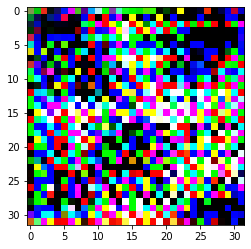

In [105]:
error_acumulado_batch_falsas = np.array([])
error_acumulado_batch_reales = np.array([])
error_acumulado_gError = np.array([])

for i in range(1,N_ITS+1):
    start = time.time()
    print("Comenzando Epoca " + str(i))

    # Crear un "batch" de imágenes falsas y otro con imágenes reales
    ruido = np.random.normal(-1,1,[TAM_LOTE,TAM_ENTRADA])
    batch_falsas = generador.predict(ruido)

    idx = np.random.randint(low=0, high=x_train.shape[0],size=TAM_LOTE)
    batch_reales = x_train[idx]

    # Entrenar discriminador con imagener falsas y reales, y en cada
    # caso calcular el error
    discriminador.trainable = True

    #las reales le digo como resultado 1 con np.ones
    #las falsas le digo como resultado 0 con np.zeros
    dError_reales = discriminador.train_on_batch(batch_reales, np.ones(TAM_LOTE))#*0.9)
    dError_falsas = discriminador.train_on_batch(batch_falsas, np.zeros(TAM_LOTE))

    error_acumulado_batch_falsas = np.append(error_acumulado_batch_falsas, dError_falsas)
    error_acumulado_batch_reales = np.append(error_acumulado_batch_reales, dError_reales)
    #print("Error de discriminador reales: ", dError_reales)
    #print("Error de discriminador falsas: ", dError_falsas)
    #congelo el discriminador
    discriminador.trainable = False

    # Entrenar GAN: se generará ruido aleatorio y se presentará a la GAN
    # como si fuesen imagenes reales
    ruido = np.random.normal(-1,1,[TAM_LOTE,TAM_ENTRADA])
    gError = gan.train_on_batch(ruido, np.ones(TAM_LOTE))
    
    error_acumulado_gError = np.append(error_acumulado_gError, gError)
    #print("Error del GAN: ", gError)
    
    if i==1 or i%100 == 0:
        ruido = np.random.normal(-1,1,100)
        ruido = np.array([ruido])
        resultado = generador.predict(ruido)
        resultado = (resultado * 0.5) + 0.5
        plt.imshow(resultado.reshape(32,32,3))
        plt.savefig("resultadosGAN-2/r"+ str(i) + ".png")
    
    end = time.time()
    print("Fin")
    print("Tiempo transcurrido: ",end - start)
    print("===================================================================")


<AxesSubplot:>

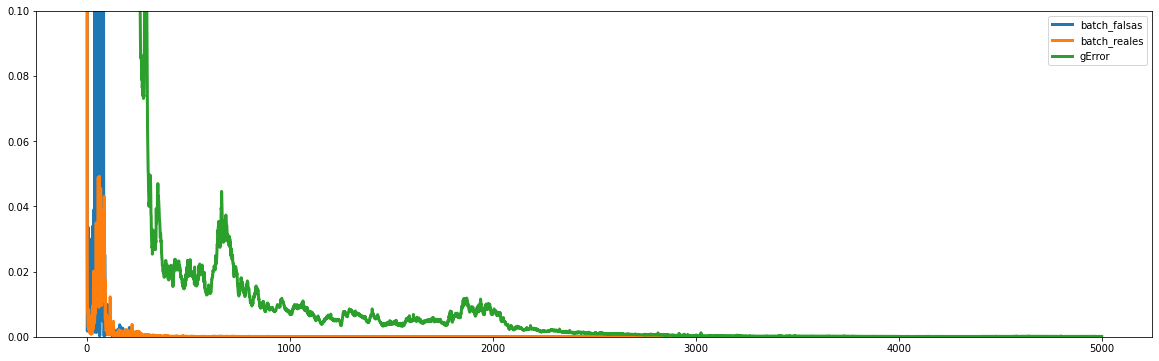

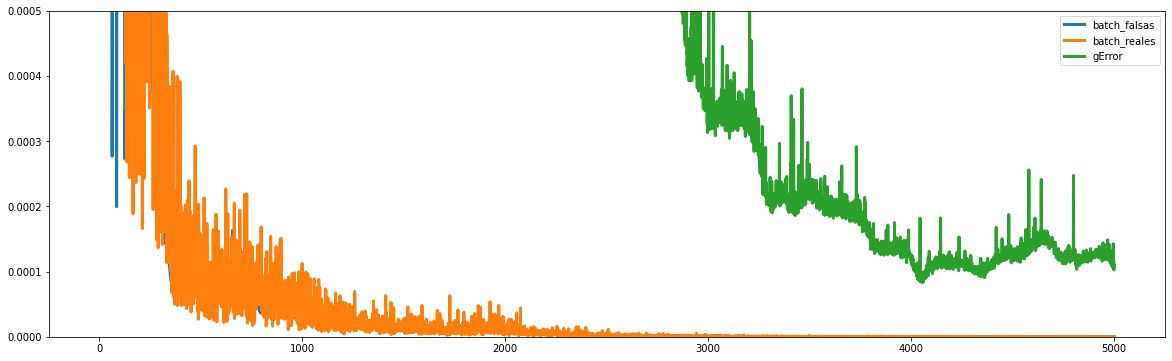

In [113]:
import seaborn as sns

t = np.linspace(1, len(error_acumulado_batch_falsas), len(error_acumulado_batch_falsas))

plt.figure(figsize=(20, 6))
plt.ylim(0, 0.1)
sns.lineplot(x=t, y=error_acumulado_batch_falsas, label="batch_falsas", linewidth=3)
sns.lineplot(x=t, y=error_acumulado_batch_reales, label="batch_reales", linewidth=3)
sns.lineplot(x=t, y=error_acumulado_gError, label="gError", linewidth=3)

plt.figure(figsize=(20, 6))
plt.ylim(0, 0.0005)
sns.lineplot(x=t, y=error_acumulado_batch_falsas, label="batch_falsas", linewidth=3)
sns.lineplot(x=t, y=error_acumulado_batch_reales, label="batch_reales", linewidth=3)
sns.lineplot(x=t, y=error_acumulado_gError, label="gError", linewidth=3)

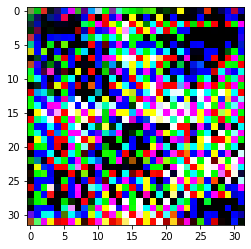

In [136]:
ruido = np.random.normal(-1,1,100)
ruido =np.array([ruido])

resultado = generador.predict(ruido)
resultado = resultado*127.5 + 127.5
resultado = np.ndarray.astype(resultado, np.uint8)

i = 0;

plt.imshow(resultado.reshape(32,32,3))
plt.show()


Parece que converge a algo. No parece q mejore. aunque le cambie la entrada no cambia la salida.

El discrimiandor esta estancado, predice como imagen real esta porqueria. Puede ser por el tamaño de la imagen